In [1]:
LEVEL = 3

ID_FILTER = '';   #  ['HOBBIES', 'HOUSEHOLD', 'FOODS', ]

In [2]:
QUANTILES = [0.005, 0.025, 0.165,  ] #   0.5,  0.75, 0.835, 0.975, 0.995]
QUANTILES = [0.25,  0.5, ]
# QUANTILES = [0.75, 0.835,  0.975, 0.995]
# QUANTILES = [0.5, ]
# QUANTILES = [0.75, 0.835, ] 
# QUANTILES = [0.975, 0.995]

In [3]:
P_DICT = \
    {1: (0.3, 0.7),   2: (0.1, 0.7),  3: (0.1, 0.5), 
     4: (0.3, 0.5),   5: (0.15, 1),    6: (0.2, 0.5),
     7: (0.1, 1),     8: (0.2, 0.5),    9: (0.1, 0.5),
    10: (0.05, 0.5), 11: (0.04, 1),  
    'HOBBIES': (0.12, 2), 'HOUSEHOLD': (0.065, 2), 'FOODS': (0.05, 0.5)}

SS_FRAC, SCALE_RANGE = P_DICT[LEVEL if LEVEL < 12 else ID_FILTER]; 
SS_FRAC = SS_FRAC * 0.8

print('LEVEL {}'.format(LEVEL)); print(ID_FILTER + '\n') if LEVEL == 12 else print(); 
print('{}/{}'.format(SS_FRAC, SCALE_RANGE))

LEVEL 3

0.08000000000000002/0.5


In [4]:
# SS_FRAC = SS_FRAC / 10

In [5]:

BAGS = 1
N_JOBS = -1


SS_PWR = 0.6
BAGS_PWR = 0


In [6]:
FEATURE_DROPS = ['item_id', '_abs_diff', 'squared_diff' ]\
                +    ['336', '300d'] 

In [7]:
# run-time parameters
CACHED_FEATURES = False
CACHE_FEATURES = False


In [8]:
PREDICT_ALL = False
PREDICT_AND_SAVE = True
KEEP_PREDICTIONS = True

In [9]:
TIME_SEED = True

In [10]:
PRICE_FEATURES = False

### Load Packages and Settings

In [11]:
import numpy as np  
import pandas as pd 

In [12]:
import psutil


In [13]:
import pickle

In [14]:
from collections import Counter
import datetime as datetime
from scipy.stats.mstats import gmean
import random

In [15]:
import gc
import gzip
import bz2

In [16]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (18,5.5)
# %config InlineBackend.figure_format='retina'


In [17]:
import seaborn as sns


In [18]:
pd.options.display.max_rows = 150



In [19]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


In [20]:
start = datetime.datetime.now()



In [21]:
if TIME_SEED:
    np.random.seed(datetime.datetime.now().microsecond)

In [22]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def memCheck():
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                             key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [23]:
def ramCheck():
    print("{:.1f} GB used".format(psutil.virtual_memory().used/1e9 - 0.7))


In [24]:
path = '/kaggle/input/m5-forecasting-uncertainty/'

In [25]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5clfs/lvl_4_low.pkl
/kaggle/input/m5clfs/lvl_2_high.pkl
/kaggle/input/m5clfs/lvl_2_mid.pkl
/kaggle/input/m5clfs/lvl_4_mid.pkl
/kaggle/input/m5clfs/lvl_5_high.pkl
/kaggle/input/m5clfs/lvl_1_low.pkl
/kaggle/input/m5clfs/lvl_5_mid.pkl
/kaggle/input/m5clfs/lvl_4_high.pkl
/kaggle/input/m5clfs/lvl_1_high.pkl
/kaggle/input/m5clfs/lvl_2_low.pkl
/kaggle/input/m5clfs/lvl_1_mid.pkl
/kaggle/input/m5clfs/lvl_5_low.pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-v9 (lvl4 lvl5 lvl6).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-v12 (lvl11).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-v8 (lvl2 lvl3).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-lvl12 (hobbies).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-v11 (lvl10).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-lvl12 (foods).pkl
/kaggle/input/m5clfs/quantile_starter_models/clf_set_Q5-F1-lvl12 (household).pkl
/kaggle/input/m5clfs/quantil

In [26]:
ramCheck()


0.3 GB used


### Load and Aggregate Training Data

In [27]:
LEVELS = [(12, ['item_id', 'store_id']),
          (11, ['state_id', 'item_id']),
          (10, ['item_id']),
          (9, ['store_id', 'dept_id']),
          (8, ['store_id', 'cat_id']),
          (7, ['state_id', 'dept_id']),
          (6, ['state_id', 'cat_id']),
          (5, ['dept_id']),
          (4, ['cat_id']),
          (3, ['store_id']),
          (2, ['state_id']),
          (1, []) ]

DOWNSTREAM = {'item_id': ['dept_id', 'cat_id'],
              'dept_id': ['cat_id'],
              'store_id': ['state_id']}

In [28]:
def aggTrain(train):
    tcd = dict([(col, 'first') for col in train.columns[1:6]])
    tcd.update( dict([(col, 'sum') for col in train.columns[6:]]))

    tadds =[]; tadd_levels= [ [12 for i in range(0, len(train))] ] 
    for idx, lvl in enumerate(LEVELS[1:]):
        level = lvl[0]
        lvls = lvl[1]

        if len(lvls) is 0:  # group all if no list provided
            lvls = [1 for i in range(0, len(train))]

        tadd = train.groupby(lvls).agg(tcd)

        # name it
        if len(lvls) == 2:
            tadd.index = ['_'.join(map(str,i)) for i in tadd.index.tolist()]
        elif len(lvls) == 1:
            tadd.index = tadd.index + '_X'
        else:
            tadd.index = ['Total_X']
        tadd.index.name = 'id'

        # fill in categorical features
        tadd.reset_index(inplace=True)
        for col in [c for c in train.columns[1:6] if c not in lvls and not  
                            any(c in z for z in[DOWNSTREAM[lvl] for lvl in lvls if lvl in DOWNSTREAM])]:
            tadd[col] = 'All'
        tadds.append(tadd)

        #levels
        tadd_levels.append([level for i in range(0, len(tadd))])

    train = pd.concat((train,*tadds), sort=False, ignore_index=True); del tadds, tadd
    levels = pd.Series(data = [x for sub_list in tadd_levels for x in sub_list], index = train.index); del tadd_levels
    for col in train.columns[1:6]:
        train[col] = train[col].astype('category')
        
    return train, levels

In [29]:
def loadTrain():
    train_cols =  pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', nrows=1)

    c_dict = {}
    for col in [c for c in train_cols if 'd_' in c]:
        c_dict[col] = np.float32

    train = pd.read_csv(path+ '/' + 'sales_train_evaluation.csv', dtype=c_dict)#.astype(np.int16, errors='ignore')

    train.id = train.id.str.split('_').str[:-1].str.join('_')
    
    train.sort_values('id', inplace=True)
    
    return train.reset_index(drop=True)

In [30]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    prices.sort_values('id', inplace=True)
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    return price_pivot

In [31]:
def getCal():
    return pd.read_csv(path+ '/' + 'calendar.csv').set_index('d')

In [32]:
cal = getCal()
cal.date = pd.to_datetime(cal.date)

day_to_cal_index = dict([(col, idx) for idx, col in enumerate(cal.index)])
cal_index_to_day = dict([(idx, col) for idx, col in enumerate(cal.index)])

cal_index_to_wm_yr_wk = dict([(idx, col) for idx, col in enumerate(cal.wm_yr_wk)])
day_to_wm_yr_wk = dict([(idx, col) for idx, col in cal.wm_yr_wk.iteritems()])

In [33]:
# Load
train = loadTrain()
price_pivot = getPricePivot()

daily_sales = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:] * price_pivot.loc[train.columns[6:].fillna(0)\
                                                                .map(day_to_wm_yr_wk)].transpose().values ), 
                            axis = 'columns')

In [34]:
# Aggregate
train, levels = aggTrain(train)
id_to_level = dict(zip(train.id, levels))
level_to_ids = dict([(level[0], list(train.id[levels == level[0]])) for idx, level in enumerate(LEVELS)])

daily_sales = aggTrain(daily_sales)[0]


In [35]:
level_multiplier = dict([ (c, (levels==c).sum() / (levels==12).sum()) for c in range(1,13)])

In [36]:
# Rescale by number of series at each level
train = pd.concat((train.iloc[:, :6], 
                        train.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')

daily_sales = pd.concat((daily_sales.iloc[:, :6], 
                        daily_sales.iloc[:, 6:].multiply( levels.map(level_multiplier), axis = 'index').astype(np.float32) ), 
                            axis = 'columns')


In [37]:
def loadSampleSub():
    return pd.read_csv(path+ '/' + 'sample_submission.csv').astype(np.int8, errors = 'ignore')

In [38]:
sample_sub = loadSampleSub()

In [39]:
assert set(train.id) == set(sample_sub.id.str.split('_').str[:-2].str.join('_'))

In [40]:
print(len(train))

42840


In [41]:
ramCheck()

1.8 GB used


In [42]:
memCheck()

                         train: 320.8 MiB
                   daily_sales: 320.8 MiB
                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                   id_to_level:  1.3 MiB
                           cal: 624.0 KiB
                        levels: 334.8 KiB
              day_to_cal_index: 72.1 KiB
              cal_index_to_day: 72.1 KiB
         cal_index_to_wm_yr_wk: 72.1 KiB


In [43]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  89 s


In [44]:
train_filter = ((train.cat_id == ID_FILTER) & (levels == LEVEL)) \
                                        | ( (levels < 12) & (levels == LEVEL) )
train = train[train_filter].reset_index(drop=True)
daily_sales = daily_sales[train_filter].reset_index(drop=True)
levels = levels[train_filter].reset_index(drop=True).astype(np.int8)

In [45]:
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1_X,All,All,All,CA_1,CA,1.422434,1.362742,0.923581,1.000656,...,1.623811,2.048213,2.199738,1.498196,1.295179,1.310266,1.356510,1.453919,1.890456,2.062644
1,CA_2_X,All,All,All,CA_2,CA,1.145949,0.999016,0.695638,0.762217,...,1.587078,2.134142,2.200722,1.389964,1.299770,1.242702,1.324041,1.558216,2.335192,2.169236
2,CA_3_X,All,All,All,CA_3,CA,1.554280,1.583142,1.241391,1.387996,...,1.982945,2.305346,2.613644,1.932109,1.811414,1.762873,1.830108,1.817645,2.319777,2.671040
3,CA_4_X,All,All,All,CA_4,CA,0.532962,0.582814,0.454575,0.472286,...,0.864218,1.067891,1.088226,0.991801,0.890456,0.826173,0.834372,0.886848,1.031814,1.179731
4,TX_1_X,All,All,All,TX_1,TX,0.838308,0.881273,0.597573,0.740571,...,1.183995,1.242047,1.639882,1.216136,1.085602,1.032142,0.901279,1.201705,1.366678,1.516563


In [46]:
print(len(train))

10


In [47]:
train_head = train.iloc[:, :6]  

In [48]:
train_head.head()

,id,item_id,dept_id,cat_id,store_id,state_id
0,CA_1_X,All,All,All,CA_1,CA
1,CA_2_X,All,All,All,CA_2,CA
2,CA_3_X,All,All,All,CA_3,CA
3,CA_4_X,All,All,All,CA_4,CA
4,TX_1_X,All,All,All,TX_1,TX


In [49]:
ramCheck()

1.1 GB used


In [50]:
# day of week; day of month; day of year;
# holiday days_til for each holiday (fade to 0 by 10 days away);
# SNAP for state_id; SNAP_lag_1; SNAP_lag_2; ewm_SNAP; days_since_last_snap; days_til_next_snap;
# EWM of product over 2, 5, 10, 20, etc. days
# EWM of sales on all snap days; EWM sales on snap gap days; EWM sales on away-snap period;
# EWM sales on that day of week
# EWM sales on snap first_day, etc.
# EWMS of ALL SALES--to spot recent trends
# some types of wavelets of overall sales, category sales, store sales, id sales, etc.
# EWM sales for each department etc.;

# various features on prior prices... EMW X-overs on this price mainly; 
#          price shock: EMA-xover all prices
#             do these with and without fill-drops back to full;
#    num_price_drops etc.

In [51]:
# DICEY:
# PCAs or SAEs of sales, RNN to predict each component etc.
# some form of clustering model run periodically *qrtly* to group items into clusters
# then inlcude EWMS and EWM x-overs on that cluster specifically; day of week clusters etc.


# Basic Models:
# LightGBM, for all window types 
# Seq2Seq RNN given all prior sequences (store, cat, product, SNAP y/n, and other info)
# 

# Other:
# some use of wavelets;
# historical sales at this time of year versus preceding sales EMWs 
# 

In [52]:
# how to describe a product:
# dept_id (categorical)
# percent Monday vs. other days; x7 (very long-run EWM, pure ratio)
# SNAP vs. normal sales, very long EWM
# CA %, TX %, WI % for item
# State_X vs. entire state for item; (multiple windows)

# state (categorical)
# store_ID (categorical)

# itemID as continuous:  X.Y;


## highly optional - item_id

In [53]:
# do some item early month late month skew, where weight 0...1 and 1....0 each day of month 

In [54]:
# most item EWMs should be done on ITEM+STORE  ITEM+STATE  ITEM


In [55]:
# replace leading zeros with nan
train['d_1'].replace(0, np.nan, inplace=True)

In [56]:
# replace leading zeros with NA
for i in range(train.columns.get_loc('d_1') + 1, train.shape[1]):
#     if i%300 == 0:
#         print(i)
#     print(train.loc[(train.iloc[:,i]==0) & (train.iloc[:,i-1].isnull()), train.columns[i]])
    train.loc[:, train.columns[i]].where( ~ ((train.iloc[:,i]==0) & (train.iloc[:,i-1].isnull())),
                                         np.nan, inplace=True)

In [57]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  94 s


In [58]:
train.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1_X,All,All,All,CA_1,CA,1.422434,1.362742,0.923581,1.000656,...,1.623811,2.048213,2.199738,1.498196,1.295179,1.310266,1.356510,1.453919,1.890456,2.062644
1,CA_2_X,All,All,All,CA_2,CA,1.145949,0.999016,0.695638,0.762217,...,1.587078,2.134142,2.200722,1.389964,1.299770,1.242702,1.324041,1.558216,2.335192,2.169236
2,CA_3_X,All,All,All,CA_3,CA,1.554280,1.583142,1.241391,1.387996,...,1.982945,2.305346,2.613644,1.932109,1.811414,1.762873,1.830108,1.817645,2.319777,2.671040
3,CA_4_X,All,All,All,CA_4,CA,0.532962,0.582814,0.454575,0.472286,...,0.864218,1.067891,1.088226,0.991801,0.890456,0.826173,0.834372,0.886848,1.031814,1.179731
4,TX_1_X,All,All,All,TX_1,TX,0.838308,0.881273,0.597573,0.740571,...,1.183995,1.242047,1.639882,1.216136,1.085602,1.032142,0.901279,1.201705,1.366678,1.516563


In [59]:
train_flipped = train.set_index('id', drop = True).iloc[:, 5:].transpose()

In [60]:
train_flipped.dtypes

id
CA_1_X    float32
CA_2_X    float32
CA_3_X    float32
CA_4_X    float32
TX_1_X    float32
TX_2_X    float32
TX_3_X    float32
WI_1_X    float32
WI_2_X    float32
WI_3_X    float32
dtype: object

In [61]:
train_flipped.head()

id,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,TX_3_X,WI_1_X,WI_2_X,WI_3_X
d_1,1.422434,1.145949,1.554280,0.532962,0.838308,1.263365,0.993768,0.886848,0.739915,1.324369
d_2,1.362742,0.999016,1.583142,0.582814,0.881273,1.291243,0.985897,0.719580,0.630371,1.376845
d_3,0.923581,0.695638,1.241391,0.454575,0.597573,0.895703,0.729747,0.512299,0.661856,1.087898
d_4,1.000656,0.762217,1.387996,0.472286,0.740571,0.968842,0.711381,0.410298,0.827156,1.053132
d_5,0.862578,0.636930,1.251886,0.503772,0.555592,0.817317,0.566087,0.000656,0.385372,0.699246


In [62]:
train_flipped.max().sort_values(ascending=False)[::3000]

id
CA_3_X    3.062644
dtype: float32

In [63]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                   id_to_level:  1.3 MiB
                           cal: 624.0 KiB
                         train: 366.9 KiB
                   daily_sales: 366.9 KiB
                           _45: 328.7 KiB
                           _58: 328.7 KiB
                    train_head: 291.1 KiB
                           _48: 290.8 KiB


In [64]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  97 s


In [65]:
ramCheck()

1.1 GB used


### Item Features

In [66]:
# EWMS
# stdev
# stdev between stores
# corr between stores


# COME BACK LATER -- descale stores--and then calculate stdev between them as % of item sales

In [67]:
item_features = []

In [68]:
tff0 = train_flipped.fillna(0)

In [69]:
# # EWM THESE OVER INTERVALS  % NONZERO DAYS
# for window in [3, 7, 15, 30, 100, 300]:
#     item_features.append( ('pct_nonzero_days_{}d_ewm'.format(window),
#                      items_flipped.ne(0).ewm(span=window,
#                                        min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half) ) )


In [70]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  97 s


### Item-Store Features

In [71]:
features = []

In [72]:
if not CACHED_FEATURES:      # basic moving averages
    for window in [3, 7, 15, 30, 100]:
        features.append(('qs_{}d_ewm'.format(window), 
                         train_flipped.ewm(span=window, 
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))
#     features[-1][1].tail(5)
    
#     np.sum(train_flipped, axis=1)

In [73]:
store_avg_qs = train_flipped[train_flipped.columns[levels == 12]].transpose()\
            .groupby(train_head.iloc[(levels == 12).values].store_id.values).mean().fillna(1)
store_dept_avg_qs = train_flipped[train_flipped.columns[levels == 12]].transpose()\
            .groupby(  ( train_head.iloc[(levels == 12).values].store_id.astype(str) + '_'
                        + train_head.iloc[(levels == 12).values].dept_id.astype(str)).values
                    ).mean().fillna(1)

# basic moving averages, after removing any store trends
scaled_sales = train_flipped / (store_avg_qs.loc[train.store_id].transpose().values); 

if levels.min() == 12:
    # get overall store and store-dept sales matched to this id;
    store_avg_qs_matched = store_avg_qs.loc[train.store_id].transpose() 
    store_dept_avg_qs_matched = store_dept_avg_qs.loc[train.store_id.astype(str) + '_'
                                                  + train.dept_id.astype(str)
                                                ].transpose() 

    store_avg_qs_matched.columns = train_flipped.columns
    store_dept_avg_qs_matched.columns = train_flipped.columns

    ratio = (store_avg_qs_matched.rolling(28).mean() / store_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
    ratio = ratio.clip ( ratio.stack().quantile(0.01), ratio.stack().quantile(0.99))
#     features.append(('store_28d_58d_ratio',  ratio.astype(np.half)))

    ratio = (store_dept_avg_qs_matched.rolling(28).mean() / store_dept_avg_qs_matched.rolling(56).mean() ) .fillna(1) - 1
    ratio = ratio.clip ( ratio.stack().quantile(0.003), ratio.stack().quantile(0.997))

#     features.append(('store_dept_28d_58d_ratio',  ratio.astype(np.half)))

    del store_avg_qs_matched, store_dept_avg_qs_matched, ratio

del store_avg_qs, store_dept_avg_qs,

In [74]:
# (store_avg_qs.transpose()['CA_3'].rolling(14).mean() / 1.5).plot();
# (  store_avg_qs.transpose()['CA_3'].rolling(28).mean() / store_avg_qs.transpose()['CA_3'].rolling(56).mean() 
#       + np.random.normal(0, 0.005, len(store_avg_qs.transpose() ) ) ).plot(legend=True);
# plt.axhline(1)

In [75]:
if not CACHED_FEATURES:
    for window in [3, 7, 15, 30, 100]:
        features.append(('qs_divbystore_{}d_ewm'.format(window), 
                         scaled_sales.ewm(span=window,
                                           min_periods = int(np.ceil(window ** 0.8))  ).mean().astype(np.half)))

In [76]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  97 s


In [77]:
# EWM THESE OVER INTERVALS  % NONZERO DAYS
if not CACHED_FEATURES:
    tff0ne0 = tff0.ne(0)
    for window in [7, 14, 28, 28*2, 28*4,  ]:  
        features.append( ('pct_nonzero_days_{}d'.format(window),
                         tff0ne0.rolling(window).mean().astype(np.half) ) )
    del tff0ne0

In [78]:
del tff0

In [79]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  97 s


In [80]:
arrs = [train_flipped, scaled_sales, ] # sales_over_all]
labels = ['qs', 'qs_divbystore', ] #'qs_divbyall']


In [81]:
if not CACHED_FEATURES:
    for lag in range(1, 10+1):
        features.append( ('qs_lag_{}d'.format(lag),
                              train_flipped.shift(lag).fillna(0).astype(np.half) ) )

In [82]:
# DIFF stats (mean abs diff, mean squraed diff)
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
#         abs_arr_diff = np.abs(arr.diff())
#         arr_diff_sq = np.power(abs_arr_diff,2)
        label = labels[idx]

        for window in [7, 14, 21, 28, 28*2, 28*4,  ]:  ## ** mean and median
            features.append( ('{}_mean_{}d'.format(label, window), 
                          arr.rolling(window).mean().astype(np.half) )  )

            features.append( ('{}_median_{}d'.format(label, window), 
                          arr.rolling(window).median().astype(np.half) )  )


            
            print('{}: {}'.format(label,window))

    #         if label == 'qs':
#             features.append( ( '{}_abs_diff_ewm_{}d'.format(label, window),
#                 abs_arr_diff.ewm(span = window,
#                                 min_periods = int(np.ceil(window ** 0.8))).mean().astype(np.half) ) )
    #         features[-1][1].tail(5)

    #         features.append( ('{}_abs_diff_over_mean_ewm_{}d'.format(label, window),
    #             ( abs_arr_diff.ewm(span = window,
    #                               min_periods = int(np.ceil(window ** 0.8)) ).mean()\
    #                      / arr.ewm(span = window,
    #                               min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half)  ) )
    #         features[-1][1].tail(5)

#             features.append( ('{}_squared_diff_ewm_{}d'.format(label, window),
#                 np.sqrt( arr_diff_sq.ewm(span = window,
#                                              min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half) ) )
    #         features[-1][1].tail(5)
    #         features.append( ('{}_rms_diff_over_mean_ewm_{}d'.format(label, window),
    #             ( np.sqrt( arr_diff_sq.ewm(span = window,
    #                                            min_periods = int(np.ceil(window ** 0.8)) ).mean())
    #                  / arr.ewm(span = window,
    #                           min_periods = int(np.ceil(window ** 0.8)) ).mean()).astype(np.half) ) )
    #         features[-1][1].tail(5)

#         del arr_diff_sq
#         del abs_arr_diff
        del arr

qs: 7
qs: 14
qs: 21
qs: 28
qs: 56
qs: 112
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 21
qs_divbystore: 28
qs_divbystore: 56
qs_divbystore: 112


In [83]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  98 s


In [84]:
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [7, 14, 28, 28*3, 28*6]:
            print('{}: {}'.format(label,window))


    #         if label=='qs':
    #             features.append( ('{}_median_{}d'.format(label, window), 
    #                                   arr.rolling(window).median().astype(np.half) )  )
    #             features[-1][1].tail(5)

            features.append( ('{}_stdev_{}d'.format(label, window), 
                                  arr.rolling(window).std().astype(np.half) )  )
    #         features[-1][1].tail(5)

    #         features.append( ('{}_stdev_over_mean_{}d'.format(label, window),
    #                               (arr.rolling(window).std() / arr.rolling(window).mean())\
    #                                       .astype(np.half)))
    #         features[-1][1].tail(5)

            if window >= 10:
                features.append( ('{}_skew_{}d'.format(label, window), 
                                      arr.rolling(window).skew().astype(np.half) )  )

                features.append( ('{}_kurt_{}d'.format(label, window), 
                                      arr.rolling(window).kurt().astype(np.half) )  )

    del arr;

qs: 7
qs: 14
qs: 28
qs: 84
qs: 168
qs_divbystore: 7
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 84
qs_divbystore: 168


In [85]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  98 s


In [86]:
if not CACHED_FEATURES:
    for idx in range(0, len(arrs)):
        arr = arrs[idx]
        label = labels[idx]
        for window in [14, 28, 56]:

            features.append( ('{}_qtile10_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.1).astype(np.half) )  )

            features.append( ('{}_qtile90_{}d'.format(label, window), 
                          arr.rolling(window).quantile(0.9).astype(np.half) )  )

            
#             features.append( ('{}_qtile60_{}d'.format(label, window), 
#                   arr.rolling(window).quantile(0.6).astype(np.half) )  )

#             features.append( ('{}_qtile40_{}d'.format(label, window), 
#                   arr.rolling(window).quantile(0.4).astype(np.half) )  )

            print('{}: {}'.format(label,window))
        del arr


qs: 14
qs: 28
qs: 56
qs_divbystore: 14
qs_divbystore: 28
qs_divbystore: 56


In [87]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  98 s


In [88]:
del arrs; del scaled_sales

In [89]:
ramCheck()

1.1 GB used


In [90]:
cal.iloc[300]

date            2011-11-25 00:00:00
wm_yr_wk                      11143
weekday                      Friday
wday                              7
month                            11
year                           2011
event_name_1                    NaN
event_type_1                    NaN
event_name_2                    NaN
event_type_2                    NaN
snap_CA                           0
snap_TX                           0
snap_WI                           0
Name: d_301, dtype: object

In [91]:
def clean_df(fr):
    early_rows = cal[cal.year == cal.year.min()].index.to_list()
    holiday_rows = cal[cal.month.isin([10, 11, 12, 1])].index.to_list()
    delete_rows = early_rows + holiday_rows
    
    MIN_DAY = 'd_{}'.format(300)
    
    if 'd' in fr.columns: # d, series stack:
        fr = fr[fr.d >= day_to_cal_index[MIN_DAY]]
        fr = fr[~fr.d.isin([  day_to_cal_index[d] for d in delete_rows])]
        
        
    else:  # pivot table
        if MIN_DAY in fr.index:
            fr = fr.iloc[ fr.index.get_loc(MIN_DAY):, :]

        if len(delete_rows) > 0:
            fr = fr[~fr.index.isin(delete_rows)]
    
    return fr;

In [92]:
def clean_features(features):
    for idx, feat_row in enumerate(features):
        fr = feat_row[1]
        fr = clean_df(fr)

        if len(fr) < len(feat_row[1]):
            features[idx] = (features[idx][0], fr)  

In [93]:
ramCheck()

1.1 GB used


In [94]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  98 s


### Cache Loader

In [95]:
pickle_dir = '/kaggle/input/m5-e300/'

if CACHED_FEATURES:
    if 'features.pbz2' in os.listdir(pickle_dir):
        with bz2.BZ2File(pickle_dir + 'features.pbz2', 'r') as handle:
            features = pickle.load(handle)
    elif 'features.pgz' in os.listdir(pickle_dir):
        with gzip.GzipFile(pickle_dir + 'features.pgz', 'r') as handle:
            features = pickle.load(handle)
        
        
#     with open(pickle_dir + 'features.pkl', 'rb') as handle:
#         features = pickle.load(handle)
   

In [96]:
ramCheck()

1.1 GB used


In [97]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  98 s


### Clean Features

In [98]:
clean_features(features)

In [99]:
clean_features(item_features)

In [100]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  98 s


In [101]:
ramCheck()

1.1 GB used


#### Save Caches

In [102]:
if CACHE_FEATURES:
#     with bz2.BZ2File('features.pbz2', 'w') as handle:
#         pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with gzip.GzipFile('features.pgz', 'w') as handle:
        pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)
    os.path.getsize('features.pgz') / 1e9

In [103]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  98 s


In [104]:
        
#     with open('features.pkl', 'wb') as handle:
#         pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [105]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')


Total Time Elapsed:  98 s


In [106]:
cal

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,
d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1965,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1
d_1966,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0
d_1967,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0


In [107]:
cal_features = pd.DataFrame()

In [108]:
cal_features['dayofweek'] =  cal.date.dt.dayofweek.astype(np.int8)
cal_features['dayofmonth'] =  cal.date.dt.day.astype(np.int8)
cal_features['season'] =  cal.date.dt.month.astype(np.half)


In [109]:
# mostly SNAP and holiday proximity
# includes SNAP early late, 11(0) 0(1)0 1(0)1 snap days, etc.
# can also put in forward and reverse SNAP EWMs;

# and of course day of week, day of week fracs, detrended EWM * day_frac, etc.

# also early in month, late in month ratio; and that times month_frac

# also month_frac, season_frac for each product; perhaps even use a sine wave filter ***

# probably store_id * days_til, state * days_til, and category * days_til

# also crucial at some point to build *MY OWN* categories (rebuild each qtr based on corrs)


### State Calendar Features

In [110]:
snap_cols = [c for c in cal.columns if 'snap' in c]


In [111]:
state_cal_features = []

In [112]:
state_cal_features.append( ( 'snap_day' , 
                                cal[snap_cols].astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_1' , 
                                cal[snap_cols].shift(1).fillna(0).astype(np.int8) ) )
state_cal_features.append( ( 'snap_day_lag_2' , 
                                cal[snap_cols].shift(2).fillna(0).astype(np.int8) ) )

In [113]:
state_cal_features.append( ( 'nth_snap_day',
            (cal[snap_cols].rolling(15, min_periods = 1).sum() * cal[snap_cols] ).astype(np.int8)  ) )

In [114]:
for window in [2, 5, 10, 30, 60]:
    state_cal_features.append( ('snap_{}d_ewm'.format(window),
                                    cal[snap_cols].ewm(span = window, adjust=False).mean().astype(np.half) ) )

In [115]:
# RENAME TO MATCH STATE_ID
def snapRename(x):
    return x.replace('snap_', '')

In [116]:
for f in range(0, len(state_cal_features)):
    state_cal_features[f] = (state_cal_features[f][0],
                                state_cal_features[f][1].rename(snapRename, axis = 'columns')) 

### Other 

In [117]:
# make sure to subtract DAY EMW from all_sales EWM matched on timeline;
# also post version of it normalized (DAY_EWM - EWM) / EWM gives % elevation DOW;
# probably use very long EWMs for this one; maybe 100-day or longer

In [118]:
# Good chance RNNs make a lot of sense for the bigger products and making sure overall totals feel right

In [119]:
# also might make sense to FEED THE LIGHTGBM the RNN trained on all past sales and predicting overall sales !
# basically stacking FORWARD using an older-training RNN; (easy enough to cache those by quarter and store outputs etc.)
# can also feed it RNN by cluster/category/store etc. (again, those are fine with very early data and help get overall levels right)
# LGB focuses on product; RNN more overall sales etc.; though can also feed it a product one, again trained earlier only;
# in theory; could be feeding forward a stack of various LightGBMs trained on before the 28 day window only; and fit within it each time etc.



In [120]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_name_1').mean()\
                .sort_values('total_sales', ascending=False)

,total_sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
event_name_1,,,,,,,,
LaborDay,13.825713,11331.800000,3.000000,9.000000,2013.00,1.000000,0.800000,0.600000
OrthodoxEaster,13.521811,11353.000000,2.000000,4.400000,2013.40,0.400000,0.800000,0.600000
SuperBowl,13.422106,11351.666667,2.000000,2.000000,2013.50,1.000000,0.833333,0.666667
Easter,12.960839,11410.400000,2.000000,3.600000,2014.00,0.400000,0.200000,0.400000
Father's day,11.991472,11296.000000,2.000000,6.000000,2012.75,0.000000,0.000000,0.000000
Pesach End,11.898983,11362.000000,2.500000,4.000000,2013.50,0.166667,0.166667,0.500000
Mother's day,11.843555,11365.333333,2.000000,5.000000,2013.50,0.500000,0.500000,0.666667
Purim End,11.793047,11356.500000,4.000000,2.833333,2013.50,0.333333,0.166667,0.333333
Eid al-Fitr,11.566939,11328.000000,3.600000,7.600000,2013.00,0.200000,0.000000,0.200000


In [121]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_type_1').mean()\
                .sort_values('total_sales', ascending=False)

,total_sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
event_type_1,,,,,,,,
Sporting,11.740263,11331.562500,3.625000,4.437500,2013.187500,0.562500,0.625000,0.562500
Cultural,11.386879,11358.351351,3.162162,4.783784,2013.432432,0.270270,0.243243,0.459459
Religious,11.290994,11347.314815,3.888889,5.148148,2013.351852,0.351852,0.370370,0.296296
National,9.661695,11339.784314,3.901961,6.803922,2013.254902,0.333333,0.333333,0.235294


In [122]:
# closest_sporting_holiday;  days_to_closest_sporting_holiday; +-3 qualifier;

In [123]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('event_name_2').mean()\
                .sort_values('total_sales', ascending=False)

,total_sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
event_name_2,,,,,,,,
Cinco De Mayo,14.169564,11315,2,5,2013,1,1,1
Father's day,13.937028,11420,2,6,2014,0,1,1
OrthodoxEaster,12.769432,11412,2,4,2014,0,0,0
Easter,7.877337,11113,2,4,2011,0,0,0


In [124]:
cal[~cal.event_name_1.isnull()][:20]

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,
d_9,2011-02-06,11102,Sunday,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
d_17,2011-02-14,11103,Monday,3,2,2011,ValentinesDay,Cultural,NaN,NaN,0,0,1
d_24,2011-02-21,11104,Monday,3,2,2011,PresidentsDay,National,NaN,NaN,0,0,0
d_40,2011-03-09,11106,Wednesday,5,3,2011,LentStart,Religious,NaN,NaN,1,1,1
d_47,2011-03-16,11107,Wednesday,5,3,2011,LentWeek2,Religious,NaN,NaN,0,0,0
d_48,2011-03-17,11107,Thursday,6,3,2011,StPatricksDay,Cultural,NaN,NaN,0,0,0
d_51,2011-03-20,11108,Sunday,2,3,2011,Purim End,Religious,NaN,NaN,0,0,0
d_86,2011-04-24,11113,Sunday,2,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
d_88,2011-04-26,11113,Tuesday,4,4,2011,Pesach End,Religious,NaN,NaN,0,0,0


In [125]:
cal[~cal.event_name_2.isnull()]

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,
d_86,2011-04-24,11113,Sunday,2,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
d_828,2013-05-05,11315,Sunday,2,5,2013,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
d_1178,2014-04-20,11412,Sunday,2,4,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
d_1234,2014-06-15,11420,Sunday,2,6,2014,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
d_1969,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [126]:
cal.date[-1] + datetime.timedelta(1)

Timestamp('2016-06-20 00:00:00')

In [127]:
cal

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,
d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1965,2016-06-15,11620,Wednesday,5,6,2016,NaN,NaN,NaN,NaN,0,1,1
d_1966,2016-06-16,11620,Thursday,6,6,2016,NaN,NaN,NaN,NaN,0,0,0
d_1967,2016-06-17,11620,Friday,7,6,2016,NaN,NaN,NaN,NaN,0,0,0


In [128]:
for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = np.where(cal.event_type_1 == etype,
                                       cal.event_name_1,
                                               np.where(cal.event_type_2 == etype,
                                                    cal.event_name_2, 'None'))

# for etype in [c for c in cal.event_type_1.dropna().unique()]:

for etype in [c for c in cal.event_type_1.dropna().unique()]:
    cal[etype.lower() + '_holiday'] = cal[etype.lower() + '_holiday'].astype('category')

In [129]:
cal[~cal.event_name_1.isnull() | ~cal.event_name_2.isnull()][[c for c in cal.columns if 'holiday' in c or 'event' in c]]

,event_name_1,event_type_1,event_name_2,event_type_2,sporting_holiday,cultural_holiday,national_holiday,religious_holiday
d,,,,,,,,
d_9,SuperBowl,Sporting,NaN,NaN,SuperBowl,None,None,None
d_17,ValentinesDay,Cultural,NaN,NaN,None,ValentinesDay,None,None
d_24,PresidentsDay,National,NaN,NaN,None,None,PresidentsDay,None
d_40,LentStart,Religious,NaN,NaN,None,None,None,LentStart
d_47,LentWeek2,Religious,NaN,NaN,None,None,None,LentWeek2
...,...,...,...,...,...,...,...,...
d_1927,Mother's day,Cultural,NaN,NaN,None,Mother's day,None,None
d_1949,MemorialDay,National,NaN,NaN,None,None,MemorialDay,None
d_1952,NBAFinalsStart,Sporting,NaN,NaN,NBAFinalsStart,None,None,None


In [130]:
pd.merge( pd.Series(np.sum(train_flipped, axis = 1), name='total_sales'), cal, 
         left_index=True, right_index=True).groupby('wday').mean()\
                .sort_values('total_sales', ascending=False)

,total_sales,wm_yr_wk,month,year,snap_CA,snap_TX,snap_WI
wday,,,,,,,
1,13.678672,11343.870504,6.327338,2013.248201,0.323741,0.327338,0.334532
2,13.546753,11343.870504,6.323741,2013.251799,0.334532,0.338129,0.327338
7,11.268440,11342.884477,6.317690,2013.256318,0.324910,0.335740,0.324910
3,10.821558,11342.884477,6.357401,2013.241877,0.328520,0.317690,0.328520
4,10.003438,11342.884477,6.353791,2013.245487,0.339350,0.335740,0.335740
6,9.944585,11342.884477,6.324910,2013.252708,0.328520,0.328520,0.328520
5,9.882066,11342.884477,6.339350,2013.249097,0.328520,0.324910,0.328520


In [131]:
# want to do rolling windows similar to this--starts on Monday the ~23rd of month (away from SNAP);
# likely upweight CV windows that are mostly in June; and upweight those points in final model especially;
# fairly crucial to bake in some forward looking estimates of RAIN / WEATHER / ETC. (likely hit in 2015 too)
# would expect using ~10-fold and ~50-fold CV (heavily weighted to this part of year) as necessary;

# in theory could train only data rows where SNAP hits mid-month (i.e. SNAP values are always live 8 - 25 days into window)

# put ZERO TRUST IN PUBLIC LB;  mainly use a weighted 10-fold of various windows, always stagged to start Monay the ~2xth away from holidays

# likely should not X-Val on Christmas or Thanksgiving;  Memorial Day; Labor Day; Independence day ideal; specify a clear last 3yr x 3 = 9 basic CV
# There is VERY HEAVY WEIGHTING ON HIGHEST SOLD ITEMS:  MODEL SHOULD LIKELY SUBSAMPLE THESE MORE HEAVILY. (most sparse mostly dropped)








### Price Features

In [132]:
def getPricePivot():
    prices = pd.read_csv(path+ '/' + 'sell_prices.csv',
                    dtype = {'wm_yr_wk': np.int16, 'sell_price': np.float32})
    prices['id'] = prices.item_id + "_" + prices.store_id
    price_pivot =  prices.pivot(columns = 'id' , index='wm_yr_wk', values = 'sell_price')
    return price_pivot


price_pivot = getPricePivot()

In [133]:
ramCheck()

1.2 GB used


In [134]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB
                          _106: 715.0 KiB
                          _127: 715.0 KiB
                         train: 366.9 KiB
                   daily_sales: 366.9 KiB
                           _45: 328.7 KiB
                           _58: 328.7 KiB


In [135]:
price_features = []

In [136]:
# price_features.append( ('price',
#                      price_pivot.fillna(method = 'ffill').fillna(-1) ) )
# price_features.append( ('null_price',
#                     price_pivot.isnull().astype(np.int8) ) )


In [137]:

# price_features.append( ('price_dollars',
#                     np.floor(price_pivot)  ) )

# price_features.append( ('price_last_two_digits',
#                     price_pivot - np.floor(price_pivot)  ) )
# price_features.append( ('price_last_digit',
#                     10 * price_pivot - np.floor(10 * price_pivot) ) )


In [138]:
if PRICE_FEATURES:
    for window in [2, 5, 13, 52]:
        price_features.append( ('price_ewm_{}w'.format(window),
            (price_pivot.ewm(span = window, adjust=False).mean()
                + np.random.normal( 0, 0.10, size = price_pivot.shape) )

                                .astype(np.half) ) )


In [139]:
if PRICE_FEATURES:
    for window in [2, 5, 13, 52]:
        price_features.append( ('price_diff_ewm_{}w_relative_to_price'.format(window),
            np.clip( ( price_pivot.diff().fillna(0).ewm(span = window, adjust=False).mean() 
                 / price_pivot.ewm(span = window, adjust=False).mean() ) 
                        * np.random.normal(1, 0.1, size = price_pivot.shape ), -1, 1)
                           .astype(np.half)  ) ) 

In [140]:
# literally raw price right now
# ewm crosses, or price - various crosses;
# days_since_cut
# days_since_raise
# days_since_active_cut
# days_since_active_raise

In [141]:
# EWM
# num null prices
# stdev
# range
# num_price_changes
# rolling price chg frequency
# diff EWM
# abs diff rolling
# diff rolling **2 ()
# diff vs prior week
# raw diff
# etc.

In [142]:
# last digit;
# last two digits

In [143]:
# ideally merge these all in last minute gives 7x the memory (!)

In [144]:
# perhaps some measure of elasticity;

In [145]:
# measure dispersion within state, and within all places;


In [146]:
# price, ewms, last two, last digit;
#  ewms with and without corrections
# num weeks with very low price; etc.
# plenty of ewm x-overs;

# consec same prices;
# etc.

# lots of stdevs and % matching;
# other descriptors; etc.
# days_since_increase
# days_since_cut;

### Assemble Series-Features Matrix

#### Dicts

In [147]:
series_to_series_id = dict([(col, idx) for idx, col in enumerate(train_flipped.columns)])
series_id_to_series = dict([(idx, col) for idx, col in enumerate(train_flipped.columns)])
series_id_level = dict([(idx, col) for idx, col in enumerate(levels)])
series_level = dict(zip(train_flipped.columns, levels))

In [148]:
series_to_item_id = dict([(x[1].id, x[1].item_id) for x in train_head[['id', 'item_id']].iterrows()])
# series_to_item_id

#### Features

In [149]:
for feature in features:
#     print('{}: {}'.format(feature[0], feature[1].shape))
    assert feature[1].shape == features[0][1].shape

In [150]:
fstack = features[0][1].stack(dropna = False)
series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16)  })
del fstack

In [151]:
for idx, feature in enumerate(features):
    if feature is not None:
        series_features[feature[0]] = feature[1].stack(dropna=False).values
        
del features 

In [152]:
ramCheck()

1.2 GB used


#### Price Features

#### Item Features

#### State Cal Features

In [153]:
# print(features[0][1].shape)
for feature in state_cal_features:
    assert feature[1].shape == state_cal_features[0][1].shape

In [154]:
fstack = state_cal_features[0][1].stack(dropna = False)

In [155]:
state_cal_series_features = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'state': fstack.index.get_level_values(1)  })
del fstack

In [156]:
for idx, feature in enumerate(state_cal_features):
    if feature is not None:
        state_cal_series_features[feature[0]] = feature[1].stack(dropna=False).values
        
# del item_features 

#### Clean Up NA

In [157]:
series_features.isnull().sum().sum()

0

In [158]:
# series_features.replace([np.inf, -np.inf], np.nan, inplace=True)
# item_series_features.replace([np.inf, -np.inf], np.nan, inplace=True)
series_features.fillna(-10, inplace=True)
# item_series_features.fillna(-10, inplace=True)


In [159]:
train_head.head()

,id,item_id,dept_id,cat_id,store_id,state_id
0,CA_1_X,All,All,All,CA_1,CA
1,CA_2_X,All,All,All,CA_2,CA
2,CA_3_X,All,All,All,CA_3,CA
3,CA_4_X,All,All,All,CA_4,CA
4,TX_1_X,All,All,All,TX_1,TX


#### Add Categoricals

In [160]:
CATEGORICALS = ['dept_id', 'cat_id', 'store_id', 'state_id', ] # 'item_id'] # never item_id; wrecks higher layers;

        
for col in CATEGORICALS:
    series_features[col] = series_features.series.map(series_id_to_series).map(
                train_head.set_index('id')[col]) #.astype('category')



In [161]:
ramCheck()

1.2 GB used


In [162]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  116 s


### Metrics and Scaling

In [163]:
def addSuffix(c):
    return c + '_validation'

In [164]:
trailing_28d_sales = daily_sales.iloc[:,6:].transpose().rolling(28, min_periods = 1).sum().astype(np.float32)

# trailing_28d_qs = train_flipped.fillna(0).rolling(28, min_periods = 1).sum().astype(np.float32)

In [165]:
train_flipped

id,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,TX_3_X,WI_1_X,WI_2_X,WI_3_X
d_1,1.422434,1.145949,1.554280,0.532962,0.838308,1.263365,0.993768,0.886848,0.739915,1.324369
d_2,1.362742,0.999016,1.583142,0.582814,0.881273,1.291243,0.985897,0.719580,0.630371,1.376845
d_3,0.923581,0.695638,1.241391,0.454575,0.597573,0.895703,0.729747,0.512299,0.661856,1.087898
d_4,1.000656,0.762217,1.387996,0.472286,0.740571,0.968842,0.711381,0.410298,0.827156,1.053132
d_5,0.862578,0.636930,1.251886,0.503772,0.555592,0.817317,0.566087,0.000656,0.385372,0.699246
...,...,...,...,...,...,...,...,...,...,...
d_1937,1.310266,1.242702,1.762873,0.826173,1.032142,1.153821,1.216792,1.063299,1.486717,1.071827
d_1938,1.356510,1.324041,1.830108,0.834372,0.901279,1.025254,1.078386,1.140702,1.517875,1.114464
d_1939,1.453919,1.558216,1.817645,0.886848,1.201705,1.393572,1.439816,1.250574,1.600525,1.353231
d_1940,1.890456,2.335192,2.319777,1.031814,1.366678,1.574943,1.545425,1.640538,1.709741,1.482125


In [166]:
fstack = train_flipped.stack(dropna = False)
weight_stack = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                    'days_since_first': (~train_flipped.isnull()).expanding().sum().stack(dropna = False).values\
                                             .astype(np.int16),
                    'trailing_vol': ( (train_flipped.diff().abs()).expanding().mean() ).astype(np.float16)\
                                                 .stack(dropna = False).values,
                    'weights': (trailing_28d_sales / 
                                    trailing_28d_sales.transpose().groupby(levels).sum().loc[levels].transpose().values)
                                     .astype(np.float16)\
                                             .stack(dropna = False).values,
                            })

del fstack

In [167]:
del trailing_28d_sales; # del daily_sales; 

In [168]:
weight_stack.dtypes

d                     int16
series                int16
days_since_first      int16
trailing_vol        float16
weights             float16
dtype: object

In [169]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
               series_features:  1.9 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB
                          _106: 715.0 KiB
                          _127: 715.0 KiB
     state_cal_series_features: 432.8 KiB
                         train: 366.9 KiB
                   daily_sales: 366.9 KiB


In [170]:
new_items = weight_stack.days_since_first < 30
weight_stack[new_items].weights.sum() / weight_stack[weight_stack.days_since_first >= 0].weights.sum()
weight_stack.loc[new_items, 'weights'] = 0


In [171]:
ramCheck()

1.2 GB used


In [172]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  119 s


### Merge Weight and Y into Main Df

In [173]:
weight_stack = clean_df(weight_stack)

In [174]:
assert len(weight_stack) == len(series_features)
assert (weight_stack.d.values == series_features.d).all()
assert (weight_stack.series.values == series_features.series).all()

In [175]:
series_features = pd.concat( (series_features, 
                weight_stack.reset_index(drop=True).iloc[:, -2:]), axis = 1,)

In [176]:
weight_stack = weight_stack.iloc[:10, :]

In [177]:
fstack = train_flipped.stack(dropna = False)
y_full = pd.DataFrame({'d': fstack.index.get_level_values(0) \
                                                .map(day_to_cal_index).values.astype(np.int16),
                     'series': fstack.index.get_level_values(1) \
                                                .map(series_to_series_id).values.astype(np.int16),
                      'y': fstack.values})
del fstack

In [178]:
ramCheck()


1.2 GB used


In [179]:
memCheck()

                    sample_sub: 87.6 MiB
                   price_pivot: 32.8 MiB
               series_features:  1.9 MiB
                   id_to_level:  1.3 MiB
                           cal: 715.0 KiB
                          _106: 715.0 KiB
                          _127: 715.0 KiB
     state_cal_series_features: 432.8 KiB
                         train: 366.9 KiB
                   daily_sales: 366.9 KiB


### Feature Merges to Build X/Y/etc.

In [180]:
def addMAcrosses(X):
    EWMS = [c for c in X.columns if 'ewm' in c and 'qs_' in c and len(c) < 12]
    for idx1, col1 in enumerate(EWMS):
        for idx2, col2 in enumerate(EWMS):
            if not idx1 < idx2:
                continue;
            
            X['qs_{}_{}_ewm_diff'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] - X[col2]
            X['qs_{}_{}_ewm_ratio'.format(col1.split('_')[1], col2.split('_')[1])] = X[col1] / X[col2]
                
    return X
    

In [181]:
def addPriceFeatures(X):
    X['wm_yr_wk'] = X.d.map(cal_index_to_wm_yr_wk)
#     print(X[['series', 'wm_yr_wk']])
#     print(price_series_features[['series', 'wm_yr_wk']])
    Xp = X.merge(price_series_features, on=['series', 'wm_yr_wk'], validate = 'm:1', suffixes = (None, None))
    
    assert len(X) == len(Xp)

    return Xp.drop(columns = 'wm_yr_wk')

In [182]:
def addCalFeatures(X):  # large block of code; easy;
    # day of week, month, season of year
    X['basedayofweek'] = X.d.map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofweek'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofweek)
    X['dayofweekchg'] = (X.days_fwd % 7).astype(np.int8)

    X['basedayofmonth'] = X.d.map(cal_index_to_day).map(cal_features.dayofmonth)
    X['dayofmonth'] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.dayofmonth)

    X['season'] =  ( ( X.d + X.days_fwd).map(cal_index_to_day).map(cal_features.season) \
                             + np.random.normal( 0, 1, len(X)) ).astype(np.half)
                        # with a full month SD of noise to not overfit to specific days;

    # holidays
    holiday_cols = [c for c in cal.columns if '_holiday' in c]
    for col in holiday_cols:
        X['base_' + col] = X.d.map(cal_index_to_day).map(cal[col])
        X[col] = ( X.d + X.days_fwd).map(cal_index_to_day).map(cal[col])

    
    return X
#     'dayofweek'

In [183]:
def convertToLinearFeatures(X):
    X = X.copy()
    for s in X.dayofweek.unique():
        X['dayofweek_{}'.format(s)] = (X.dayofweek == s).astype(np.int8)
    X.drop( columns = X.columns[X.dtypes == 'category'], inplace=True)
    X['daysfwd_sqrt'] = (X.days_fwd ** 0.5).astype(np.half)
    
    return X

In [184]:
def addStateCalFeatures(X):  
    if (X.state_id == 'All').mean() > 0:
        print('No State Ids')
        return X;
    
    def rename_scf(c, name = 'basedate'):
        return c if (c=='d' or c == 'state') else name + '_' + c
    
    X['future_d'] = ( X.d + X.days_fwd)
    X['state'] = X.state_id.astype('object')
#     return X
#     print(X.shape)
#     print(X.head())
    
    nX = X.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(rename_scf, axis = 'columns'),
                                         on = ['d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    
    nX = nX.merge(state_cal_series_features[['state', 'd', 'snap_day', 'nth_snap_day']]
                 .rename(columns = {'d': 'future_d'}), 
                                         on = ['future_d', 'state'],  
             validate='m:1', how = 'inner', suffixes = (False, False)) 
    
    nX.drop(columns = ['state', 'future_d'], inplace=True)
    
    assert len(nX) == len(X)
    
    
    
    return nX

In [185]:
def add_item_features(X):  
    return X
#     X['item_catno'] = X.series.map(series_id_to_series).map(series_to_item_id).map(item_id_to_item_catno)

#     nX = X.merge(item_series_features.rename(columns = {'series' : 'item_catno'}), 
#                                         on = ['d', 'item_catno'],  
#             validate='m:1', how = 'inner').drop(columns = 'item_catno')
#     assert len(nX) == len(X)
#     return nX

In [186]:
# put in stuff like EWM of Sunday sales, etc. (and then ratio these back; and dummy select that day)

def state_features(state):  # basic state trends--etc.
    return None;

def category_features(cat): # recent EWMs for cat--lots of options;
    return None;

def store_features(store):  # obvious EWMs, recent splits of each category, etc.
    return None;



# and put in dummies for each obviously as a category feature;

# even better to just build models to predict each;

In [187]:
VALIDATION = -1; # 2016 # pure holdout from train and prediction sets;

In [188]:
def getXYG(X, scale_range = None, oos = False):
    start_time = datetime.datetime.now(); 

    # ensure it's in the train set, and days_forward is actually *forward*
    X.drop( X.index[ (X.days_fwd < 1) |
           (  ~oos  &  ( X.d + X.days_fwd > cal.index.get_loc(train_flipped.index[-1])  )    ) ], inplace=True)
    g = gc.collect()
    
    
    X = addMAcrosses(X)
    
    if PRICE_FEATURES:
        X = addPriceFeatures(X)

    X = addCalFeatures(X)
    X = addStateCalFeatures(X)
    
    # noise to time-static features
    for col in [c for c in X.columns if 'store' in c and 'ratio' in c]:
        X[col] = X[col] + np.random.normal(0, 0.1, len(X))
        print('adding noise to {}'.format(col))
    

    # match with Y
    if 'y' not in X.columns:
        st = datetime.datetime.now(); 
        X['future_d'] = X.d + X.days_fwd
        if oos:  
            X['y'] = -1
        else:  
            X = X.merge(y_full.rename(columns = {'d': 'future_d'}), on = ['future_d', 'series'],
                       )#    suffixes = (None, None), validate = 'm:1')
#     X['yo'] = X.y.copy()
    g = gc.collect()
    
    scaler_columns = [c for c in X.columns if c in weight_stack.columns[2:]]
    scalers = X[scaler_columns].copy()
    y = X.y
    groups = pd.Series(cal.iloc[(X.d + X.days_fwd)].year.values, X.index).astype(np.int16)
    
    # feature and other drops
    if len(FEATURE_DROPS) > 0:
        feat_drops = [c for c in X.columns if any(z in c for z in FEATURE_DROPS)]
        print('dropping {} features; anything containing {}'.format(len(feat_drops), FEATURE_DROPS))
        print('   -- {}'.format(feat_drops))
    else:
        feat_drops = []
        
    # final drops
    X.drop(columns = scaler_columns + (['future_d'] if 'future_d' in X.columns else []) + ['y'] + feat_drops , inplace=True)

    scalers['scaler'] = scalers.trailing_vol.copy()
    
    # randomize scaling
    if scale_range > 0:
        scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.normal(0, 0.5, len(X))) )

#         scalers.scaler = scalers.scaler * np.exp( scale_range * ( np.random.rand(len(X)) - 0.5) )

    
    # now rescale y and  'scaled variable' in X by its vol
    for col in [c for c in X.columns if 'qs_' in c and 'ratio' not in c]:
        X[col] = np.where( X[col] == -10, X[col], (X[col] / scalers.scaler).astype(np.half)) 
    y = y / scalers.scaler
    
    
    yn = (oos == False) & (y.isnull() | (groups==VALIDATION)) 

    
    print("\nXYG Pull Time: {}".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    
    return (X[~yn], y[~yn], groups[~yn], scalers[~yn])

In [189]:
# need to apply series_scaler upfront
# need to subsample by wtg_avg_price upfront
# need to filter out trailing_28d_sales = 0 upfront

In [190]:
def getSubsample(frac, level = 12, scale_range = 0.1, n_repeats = 1, drops = True, post_process_X = None):
    start_time = datetime.datetime.now(); 

    wtg_mean = series_features.weights[(series_features.series.map(series_id_level) == level)].mean()
    ss = series_features.weights / wtg_mean * frac
    
    X = series_features[  (ss > np.random.rand(len(ss)) ) 
                              & (series_features.series.map(series_id_level) == level) ]
    ss =  X.weights / wtg_mean   * frac 
      
    print('{} series that seek oversampling'.format( (ss > 1). sum() ) )
    print( ss[ss>1].sort_values()[-5:])
    
    extras = []
    
    while ss.max() > 1:
        ss = ss - 1
        extras.append( X[ ss > np.random.rand(len(ss))] )
        
    if len(extras) > 0:
        print(' scaled EWMS of extras:')
        print( ( extras[-1].qs_15d_ewm / extras[-1].trailing_vol)[-5:] )

    if len(extras) > 0:
        X = pd.concat((X, *extras))
    else:
        X = X.copy()
    
    
    X['days_fwd'] = (np.random.randint(0, 28, size = len(X)) + 1).astype(np.int8)
    
    if n_repeats > 1:
         X = pd.concat([X] * n_repeats)

    g = gc.collect()
    
    X, y, groups, scalers = getXYG(X, scale_range)
    ramCheck()
    g = gc.collect()
    if drops:
        X.drop(columns = ['d', 'series'], inplace=True)
    
    if post_process_X is not None:
        X = post_process_X(X)
    
    print(X.shape)
    print("\nSubsample Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))

    return X, y, groups, scalers

In [191]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  123 s


### Modeling

In [192]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import HuberRegressor
import lightgbm as lgb

In [193]:
# from sklearn.linear_model import HuberRegressor, ElasticNet

In [194]:
def quantile_loss(true, pred, quantile = 0.5):
    loss = np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) )
    return np.mean(loss)   
 

In [195]:
def quantile_scorer(quantile = 0.5):
    return make_scorer(quantile_loss, False, quantile = quantile)

In [196]:
lgb_quantile_params = {     # fairly well tuned, with high runtimes 
                'max_depth': [10, 20],
                'n_estimators': [   200, 300, 350, 400, ],   
                'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
                'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 130, 170, 200, 300, 500, 700, 1000 ],
                'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
                'num_leaves': [ 20, 30, 30, 30, 50, 70, 90, ],
                'learning_rate': [  0.02, 0.03, 0.04, 0.04, 0.05, 0.05, 0.07, ],   #, 0.02 is rare      
                'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
                'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
                'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
                'subsample': [  0.9, 1],
                'subsample_freq': [1],
                'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
}

In [197]:
def trainLGBquantile(x, y, groups, cv = 0, n_jobs = -1, alpha = 0.5, **kwargs):
    clfargs = kwargs.copy(); clfargs.pop('n_iter', None)
    clf = lgb.LGBMRegressor(verbosity=-1, hist_pool_size = 1000,  objective = 'quantile', alpha = alpha,
                            importance_type = 'gain',
                            seed = datetime.datetime.now().microsecond if TIME_SEED else None,
                             **clfargs,
                      )
    print('\n\n Running Quantile Regression for \u03BC={}\n'.format(alpha))
    params = lgb_quantile_params
    
    return trainModel(x, y, groups, clf, params, quantile_scorer(alpha), n_jobs, **kwargs)

In [198]:
huber_params = {
    'epsilon': [ 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7,  ],
    'alpha': [1e-3, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
}

In [199]:
def trainHuber(x, y, groups, cv = 0, n_jobs = -1, alpha = 0.5, **kwargs):
    clfargs = kwargs.copy(); clfargs.pop('n_iter', None)
    clf = HuberRegressor(max_iter = 500)
    print('\n\n Running Huber Regressor for \u03BC={}\n'.format(alpha))
    
#     x = convertToLinearFeatures(x)
    
    return trainModel(x, y, groups, clf, huber_params, 'neg_mean_absolute_error', n_jobs, **kwargs)

In [200]:
# def trainLGB(x, y, groups, cv = 0, n_jobs = -1, **kwargs):
#     clf = lgb.LGBMRegressor(verbosity=-1, hist_pool_size = 1000,  
#                             importance_type = 'gain', 
#                             seed = datetime.datetime.now().microsecond if TIME_SEED else None,
#                            )
#     params = lgb_params

#     return trainModel(x, y, groups, clf, params, cv, n_jobs,  **kwargs)

In [201]:
def trainModel(x, y, groups, clf, params, cv = 0, n_jobs = None, 
                   verbose=0, splits=None, **kwargs):
    if n_jobs is None:
        n_jobs = -1
    folds = LeaveOneGroupOut()
    clf = RandomizedSearchCV(clf, params, cv=  folds, 
                             n_iter= ( kwargs['n_iter'] if len(kwargs) > 0 and 'n_iter' in kwargs else 4), 
                            verbose = 0, n_jobs = n_jobs, scoring = cv)
    f = clf.fit(x, y, groups)
    print(pd.DataFrame(clf.cv_results_['mean_test_score'])); print();  

    best = clf.best_estimator_;  print(best)
    print("\nBest In-Sample CV: {}\n".format(np.round(clf.best_score_,4)))

    return best

In [202]:
def runQBags(n_bags = 3, model_type = trainLGBquantile, data = None, quantiles = [0.5], **kwargs):
    start_time = datetime.datetime.now(); 
    
    clf_set = []; loss_set = []
    for bag in range(0, n_bags):
        print('\n\n  Running Bag {} of {}\n\n'.format(bag+1, n_bags))
        if data is None:
            X, y, groups, scalers = getSubsample()
        else:
            X, y, groups, scalers = data

        group_list = [*dict.fromkeys(groups)]   
        group_list.sort()
        print("Groups: {}".format(group_list))

        clfs = []; preds = []; ys=[]; datestack = []; losses = pd.DataFrame(index=QUANTILES)
        for group in group_list:
            print('\n\n   Running Models with {} Out-of-Fold\n\n'.format(group))
            x_holdout = X[groups == group]
            y_holdout = y[groups == group]
            
            ramCheck()
            model = model_type 
            
            q_clfs = []; q_losses = []
            for quantile in quantiles:
                set_filter = (groups != group) \
                        & (np.random.rand(len(groups)) < 
                                 quantile_wts[quantile] ** (0.35 if LEVEL >=11 else 0.25) )
                clf = model(X[set_filter], y[set_filter], groups[set_filter], 
                                alpha = quantile, **kwargs) 
                q_clfs.append(clf)

                predicted = clf.predict(x_holdout)

                q_losses.append((quantile, quantile_loss(y_holdout, predicted, quantile)))
                print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, q_losses[-1][1] ) )
                
                preds.append(predicted)
                ys.append(y_holdout)
            
            clfs.append(q_clfs)
            print("\nLevel {} OOS Losses for Bag {} in {}:".format(level, bag+1, group))
            print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4))
            losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
            print("\nElapsed Time So Far This Bag: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
            
#         y_pred = np.concatenate(preds)
#         y_ho = np.concatenate(ys)
        
        clf_set.append(clfs)
        print("\nLevel {} Year-by-Year OOS Losses for Bag {}:".format(level, bag, group))
        print(losses)
        
        loss_set.append(losses)
        print("\nModel Bag Time: {}\n".format(str(datetime.datetime.now() - start_time).split('.', 2)[0] ))
    return clf_set, loss_set

In [203]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  123 s


In [204]:
level_os = dict([(idx, 1/val) for (idx,val) in level_multiplier.items()])
# level_os

In [205]:
QUANTILE_LEVELS = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
QUANTILE_WTS = [0.1, 0.2, 0.6, 0.8, 1, 0.9, 0.7, 0.2, 0.1,]
    
quantile_wts = dict(zip(QUANTILE_LEVELS, QUANTILE_WTS))

### Actually Run Model

In [206]:
print(SS_FRAC)

clf_set = {}; loss_set = {}
for level in levels.unique():
    print("\n\n\nRunning Models for Level {}\n\n\n".format(level))
    clf_set[level], loss_set[level] = runQBags(n_bags = int(BAGS * level_os[level] ** BAGS_PWR), 
                                               model_type = trainLGBquantile, 
                                               data = getSubsample(SS_FRAC * level_os[level] ** SS_PWR, 
                                                                   level, SCALE_RANGE),
                                                    n_iter =  int( (2.2 if LEVEL <= 9 else 1.66) * (16-level) ) ,
                  quantiles = QUANTILES,
                   n_jobs = N_JOBS) 
# clfs

0.08000000000000002



Running Models for Level 3



10810 series that seek oversampling
432    18.640625
322    18.640625
402    18.656250
412    18.671875
422    18.687500
Name: weights, dtype: float16
 scaled EWMS of extras:
6912    10.382812
6932     9.945312
6952    10.023438
6972    10.257812
7262     9.867188
dtype: float16
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:01
1.2 GB used
(103976, 130)

Subsample Time: 0:00:02



  Running Bag 1 of 1


Groups: [2012, 2013, 2014, 2015, 2016]


   Running Models with 2012 Out-of-Fold


1.2 GB used


 Running Quantile Regression for μ=0.25

           0
0  -0.215730
1  -0.215985
2  -0.219948
3  -0.216231
4  -0.226648
5  -0.234051
6  -0.232938
7  -0.217178
8  -0.220895
9  -0.217427
10 -0.219960
11 -0.215797
12 -0.217419
13 -0.216711
14 -0.215447
15 -0.226792
16 -0.278920
17 -0.220428
18 -0.218893
19 -0.320725
20 -0.230571
21 -0.232855
22 -0.219194
23 -0.2178

In [207]:
for level in loss_set.keys():
    print("\n\nLevel {}:".format(level))
    for idx, losses in enumerate(loss_set[level]):
        print(losses)
        print()
    print(); print()
    



Level 3:
        2012    2013    2014    2015    2016
0.25  0.2359  0.2255  0.2064  0.2036  0.2156
0.50  0.2995  0.2757  0.2509  0.2564  0.2746





In [208]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  12449 s


In [209]:
# clf_set = pickle.load(open('/kaggle/input/m5clfs/clf_set_2020_06_15_lvl2-low.pkl','rb'))

### Import Classifiers

### Display

In [210]:
for level in clf_set.keys():
    print("Level {}:".format(level))
    
    for idx, q in enumerate(QUANTILES):
        print(u'\n\n      Regressors for \u03BC={}:\n'.format(q))
        for clf in [q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]:
            print(clf)
    
    print(); print()


Level 3:


      Regressors for μ=0.25:

LGBMRegressor(alpha=0.25, boosting_type='gbdt', cat_smooth=0.5,
              class_weight=None, colsample_bynode=0.65, colsample_bytree=0.8,
              hist_pool_size=1000, importance_type='gain', learning_rate=0.04,
              max_depth=20, min_child_samples=10, min_child_weight=0.005,
              min_split_gain=0.01, n_estimators=350, n_jobs=-1, num_leaves=50,
              objective='quantile', random_state=None, reg_alpha=10,
              reg_lambda=0, seed=733638, silent=True, subsample=1,
              subsample_for_bin=200000, subsample_freq=1, verbosity=-1)
LGBMRegressor(alpha=0.25, boosting_type='gbdt', cat_smooth=1, class_weight=None,
              colsample_bynode=0.3, colsample_bytree=0.9, hist_pool_size=1000,
              importance_type='gain', learning_rate=0.05, max_depth=20,
              min_child_samples=30, min_child_weight=0.1, min_split_gain=0.01,
              n_estimators=400, n_jobs=-1, num_leaves=30, objectiv

In [211]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  12449 s


In [212]:
with open('clf_set.pkl', 'wb') as handle:
    pickle.dump(clf_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [213]:
ramCheck()

2.0 GB used


### Feature Importance

In [214]:
def show_FI(model, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fis = model.feature_importances_
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1][:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    

In [215]:
def avg_FI(all_clfs, featNames, featCount, title = "Feature Importances"):
    # 1. Sum
    clfs = []
    for clf_set in all_clfs:
        for clf in clf_set:
            clfs.append(clf);
    fi = np.zeros( (len(clfs), len(clfs[0].feature_importances_)) )
    for idx, clf in enumerate(clfs):
        fi[idx, :] = clf.feature_importances_
    avg_fi = np.mean(fi, axis = 0)

    # 2. Plot
    fis = avg_fi
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(fis)[::-1]#[:featCount]
    #print(indices)
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fis[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title(title + ' - {} classifiers'.format(len(clfs)))
    
    return pd.Series(fis[indices], featNames[indices])

In [216]:
def linear_FI_plot(fi, featNames, featCount):
   # show_FI_plot(model.feature_importances_, featNames, featCount)
    fig, ax = plt.subplots(figsize=(6, 5))
    indices = np.argsort(np.absolute(fi))[::-1]#[:featCount]
    g = sns.barplot(y=featNames[indices][:featCount],
                    x = fi[indices][:featCount] , orient='h' )
    g.set_xlabel("Relative importance")
    g.set_ylabel("Features")
    g.tick_params(labelsize=12)
    g.set_title( " feature importance")
    return pd.Series(fi[indices], featNames[indices])

In [217]:
for level in clf_set.keys():
    X = getSubsample(SS_FRAC * level_os[level] ** SS_PWR * 0.01, level, SCALE_RANGE)[0]
    print("Level {}:".format(level))
    for idx, q in enumerate(LEVEL_QUANTILES[level]):
        f = avg_FI([[q_clfs[idx] for clfs in clf_set[level] for q_clfs in clfs]], X.columns, 25, 
                       title = "Level {} \u03BC={} Feature Importances".format(level, q))
    print(); print()

0 series that seek oversampling
Series([], Name: weights, dtype: float16)
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00
2.0 GB used
(1101, 130)

Subsample Time: 0:00:01

Level 3:


NameError: name 'LEVEL_QUANTILES' is not defined

In [218]:
ramCheck()

2.0 GB used


In [219]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  12452 s


### Predict

In [220]:
def avg(arr, axis = 0):
#     print( (arr<0).sum() )
#     return gmean(np.clip(arr, 0, None), axis = axis)
    return np.median(arr, axis = axis)

In [221]:
def predictSet(X, y, groups, scalers, clf_set):
    start_time = datetime.datetime.now(); 
    
    group_list = [*dict.fromkeys(groups)]   
    group_list.sort()
#     print(group_list)
    
    y_unscaled = y * scalers.scaler
    
    all_preds = []; ys=[]; gs = []; xs = []; scaler_stack = []
    for group_idx, group in enumerate(group_list):
        g = gc.collect()
        x_holdout = X[groups == group]
        y_holdout = y_unscaled[groups == group] 
        scalers_holdout = scalers[groups == group]
        groups_holdout = groups[groups == group]
        
        preds = np.zeros( (len(QUANTILES), len(y_holdout)), dtype=np.half)
        for q_idx, quantile in enumerate(QUANTILES):            
            q_preds = np.zeros( ( len(clf_set), len(y_holdout) ) )
            for bag_idx, clf in enumerate(clf_set):
                x_clean = x_holdout.drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])
                if group_idx >= len(clf_set[bag_idx]): # if out of sample year, blend all years
                    qs_preds = np.zeros( (group_idx, len(x_clean)) )
                    for gidx in range(group_idx):
                        qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean)
                    q_preds[bag_idx, :] = np.mean(qs_preds, axis = 0)
                else:
                    q_preds[bag_idx, :] = clf_set[bag_idx][group_idx][q_idx].predict(x_clean)
                
            q_preds = avg(q_preds) * scalers_holdout.scaler

            preds[q_idx, :] = q_preds
            
#             print(u"{} \u03BC={:.3f}: {:.4f}".format(group, quantile, quantile_loss(y_holdout, q_preds, quantile) ) )
        
        all_preds.append(preds)
        xs.append(x_holdout)
        ys.append(y_holdout)
        gs.append(groups_holdout)
        scaler_stack.append(scalers_holdout)
        print()
    y_pred = np.hstack(all_preds)
    scaler_stack = pd.concat(scaler_stack)
    y_true = pd.concat(ys)
    groups = pd.concat(gs)
    X = pd.concat(xs)
    
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return y_pred, y_true, groups, scaler_stack, X

In [222]:
len(clf_set[1][0][0])

KeyError: 1

In [223]:
def predictOOS(X, scalers, clf_set):
    start_time = datetime.datetime.now(); 
    
    group_list = [1 + i for i in range(0, len(clf_set[0]))]   
    print(group_list)
    
    divisor = sum(group_list)
    print([g / divisor for g in group_list])
    
    x_holdout = X
    scalers_holdout = scalers 

    preds = np.zeros( (len(clf_set[0][0]), len(x_holdout)), dtype=np.half)
    for q_idx in range( len(clf_set[0][0])): # loop over quantiles            
        q_preds = np.zeros( ( len(clf_set), len(x_holdout) ) )
        for bag_idx, clf in enumerate(clf_set):
            x_clean = x_holdout.drop(columns = [c for c in x_holdout.columns if c=='d' or c=='series'])

            qs_preds = np.zeros( (len(group_list), len(x_clean)) )
            for gidx in range(len(group_list)):
                qs_preds[gidx, :] = clf_set[bag_idx][gidx][q_idx].predict(x_clean) * (gidx + 1) / divisor
            q_preds[bag_idx, :] = np.sum(qs_preds, axis = 0)

        q_preds = avg(q_preds) * scalers_holdout.scaler

        preds[q_idx, :] = q_preds
 
    end_time = datetime.datetime.now(); 
    print("Bag Prediction Time: {}".format(str(end_time - start_time).split('.', 2)[0] ))
    return preds

In [224]:
def wspl(true, pred, weights, trailing_vol, quantile = 0.5):
    loss = weights * np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) ) / trailing_vol
    return np.mean(loss) / np.mean(weights)   
 

### Random Sample Scoring

In [225]:
VALIDATION = -1

In [226]:
RSEED = 11
EVAL_FRAC = SS_FRAC * (1 if levels.max() < 11 else 1/2) 
EVAL_PWR = 0.6

In [227]:
SCALE_RANGE_TEST = SCALE_RANGE
N_REPEATS = 20 if ID_FILTER != 'FOODS' else 10

In [228]:
np.random.seed(RSEED)

In [229]:
qls = {}
for level in clf_set.keys():
    print("\n\n\nLevel {}\n\n\n".format(level))
    X, y, groups, scalers = getSubsample(EVAL_FRAC * level_os[level] ** EVAL_PWR, level, 
                                         SCALE_RANGE_TEST, n_repeats = N_REPEATS, drops=False)
    if len(X) == 0:
        print("No Data for Level {}".format(level))
        continue;
        
#     days_fwd = X.days_fwd

    y_pred, y_true, groups, scaler_stack, X = predictSet(X, y, groups, scalers, clf_set[level]); 
   # assert (y_true == y.values * scalers.trailing_vol).all()

    predictions = pd.DataFrame(y_pred.T, index=y_true.index, columns = QUANTILES)
    predictions['y_true'] = y_true.values
    predictions = pd.concat((predictions, scaler_stack), axis = 'columns')
    predictions['group'] = groups.values
    predictions['series'] = X.series
    predictions['d'] = X.d
    predictions['days_fwd'] = X.days_fwd
    
    
    
    losses = pd.DataFrame(index=QUANTILES)
    for group in groups.unique():
        subpred = predictions[predictions.group == group]
        q_losses = []
        for quantile in QUANTILES:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  1, subpred.trailing_vol, quantile)))
        losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
    qls[level] = [losses]    




Level 3



10810 series that seek oversampling
432    18.640625
322    18.640625
402    18.656250
412    18.671875
422    18.687500
Name: weights, dtype: float16
 scaled EWMS of extras:
6872    10.117188
6882    10.406250
6892    10.804688
6932     9.945312
6942     9.921875
dtype: float16
dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:33
2.8 GB used
(2081020, 132)

Subsample Time: 0:00:36






Bag Prediction Time: 0:01:19


In [230]:
ramCheck()

2.9 GB used


In [231]:
predictions = predictions.groupby(['series', 'd', 'days_fwd']).agg(
                dict([(col, 'mean') for col in predictions.columns 
                          if col not in ['series', 'd', 'days_fwd']]\
                         + [('days_fwd', 'count')])  )\
            .rename(columns = {'days_fwd': 'ct'}).reset_index()
predictions.head()

,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct
0,0,368,2,1.189453,1.246094,1.400131,0.172485,0.119629,0.189488,2012,20
1,0,368,6,0.965820,1.014648,1.036077,0.172485,0.119629,0.186096,2012,60
2,0,368,10,1.341797,1.396484,1.791735,0.172485,0.119629,0.202630,2012,20
3,0,368,12,1.038086,1.060547,1.204985,0.172485,0.119629,0.199979,2012,20
4,0,368,20,0.894531,0.916504,0.925877,0.172485,0.119629,0.181813,2012,20


In [232]:
predictions.sort_values('ct', ascending = False).head(5)

,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct
22142,2,770,1,2.404297,2.554688,2.406035,0.205200,0.158203,0.222087,2013,120
23169,2,851,23,1.845703,1.922852,2.068875,0.206055,0.172974,0.211211,2013,100
23582,2,884,12,2.400391,2.505859,2.334208,0.207031,0.174927,0.203362,2013,100
26655,2,1243,27,1.868164,1.946289,2.022630,0.216553,0.182129,0.221618,2014,100
25920,2,1187,10,2.554688,2.636719,2.342079,0.218262,0.179932,0.231197,2014,100


In [233]:
len(predictions)

87731

In [234]:

    losses = pd.DataFrame(index=QUANTILES)
    for group in groups.unique():
        subpred = predictions[predictions.group == group]
        q_losses = []
        for quantile in QUANTILES:
            q_losses.append((quantile, wspl(subpred.y_true, subpred[quantile], 
                                  subpred.ct, subpred.trailing_vol, quantile)))
#             print(np.round(pd.DataFrame(q_losses).set_index(0)[1], 4))
        losses[group] = np.round(pd.DataFrame(q_losses).set_index(0)[1], 4).values
        
        
    qls[level] = [losses]
    
    print("\n\n\nLevel {} Year-by-Year OOS Losses for Evaluation Bag {}:".format(level, 1))
    print(losses); print(); print()
        
    print(BAGS)
    print(SS_FRAC)
    print(X.shape); #del X
    print(SCALE_RANGE_TEST)
    print(N_REPEATS)
    
    




Level 3 Year-by-Year OOS Losses for Evaluation Bag 1:
        2012    2013    2014    2015    2016
0.25  0.2235  0.2097  0.1931  0.1925  0.2059
0.50  0.2858  0.2581  0.2339  0.2408  0.2580


1
0.08000000000000002
(2081020, 132)
0.5
20


In [235]:
predictions.tail()

,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct
87726,9,1917,15,1.602539,1.738281,1.860938,0.176514,0.083923,0.197353,2016,40
87727,9,1917,16,1.599609,1.737305,1.933093,0.176514,0.083923,0.185476,2016,20
87728,9,1917,17,1.149414,1.221680,1.278124,0.176514,0.083923,0.190558,2016,20
87729,9,1917,19,1.003906,1.042969,1.071827,0.176514,0.083923,0.203696,2016,20
87730,9,1917,23,1.275391,1.382812,1.560184,0.176514,0.083923,0.193373,2016,20


In [236]:
predictions['future_d'] = predictions.d + predictions.days_fwd

In [237]:
for quantile in QUANTILES:
    true = predictions.y_true
    pred = predictions[quantile]
    trailing_vol= predictions.trailing_vol
    
    predictions['loss_{}'.format(quantile)] = \
         np.where(true >= pred, 
                        quantile*(true-pred),
                        (1-quantile)*(pred - true) ) / trailing_vol
    
predictions['loss'] = predictions[[c for c in predictions.columns if 'loss_' in str(c)]].sum(axis = 1)  
predictions['wtg_loss'] = predictions.loss * predictions.ct / predictions.ct.mean()    

In [238]:
predictions.head()

,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct,future_d,loss_0.25,loss_0.5,loss,wtg_loss
0,0,368,2,1.189453,1.246094,1.400131,0.172485,0.119629,0.189488,2012,20,370,0.305357,0.446523,0.751880,0.633950
1,0,368,6,0.965820,1.014648,1.036077,0.172485,0.119629,0.186096,2012,60,374,0.101830,0.062118,0.163949,0.414702
2,0,368,10,1.341797,1.396484,1.791735,0.172485,0.119629,0.202630,2012,20,378,0.652140,1.145751,1.797891,1.515899
3,0,368,12,1.038086,1.060547,1.204985,0.172485,0.119629,0.199979,2012,20,380,0.241904,0.418698,0.660601,0.556988
4,0,368,20,0.894531,0.916504,0.925877,0.172485,0.119629,0.181813,2012,20,388,0.045433,0.027172,0.072605,0.061217


In [239]:
# predictions.groupby('future_d').count()

In [240]:
predictions.groupby('series').loss.sum()

series
0    3690.505085
1    3329.095857
2    6344.780972
3    3277.059634
4    3088.761553
5    4051.403862
6    3970.758659
7    3354.307896
8    5774.574350
9    3430.575899
Name: loss, dtype: float64

In [241]:
predictions.groupby('series').wtg_loss.sum()

series
0    3784.486569
1    3243.537894
2    7087.513615
3    3058.398072
4    2966.282995
5    4032.343883
6    3911.911373
7    3202.550905
8    5678.222526
9    3373.595973
Name: wtg_loss, dtype: float64

In [242]:
predictions.groupby('series').wtg_loss.sum().sum()

40338.8438049548

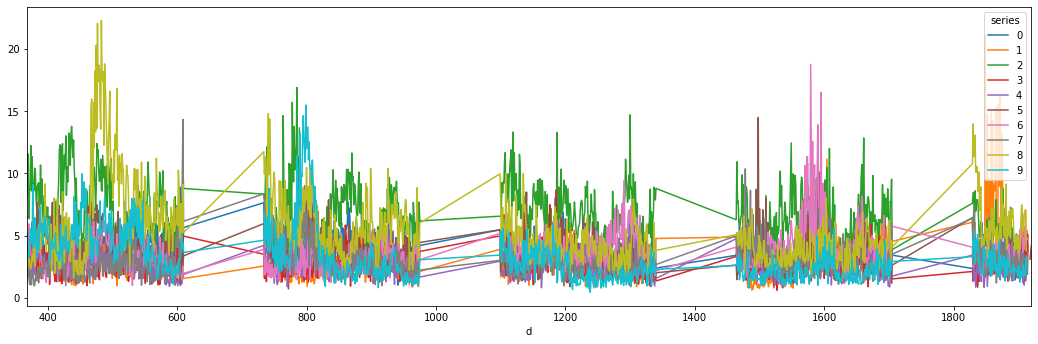

In [243]:
predictions.groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss').plot()

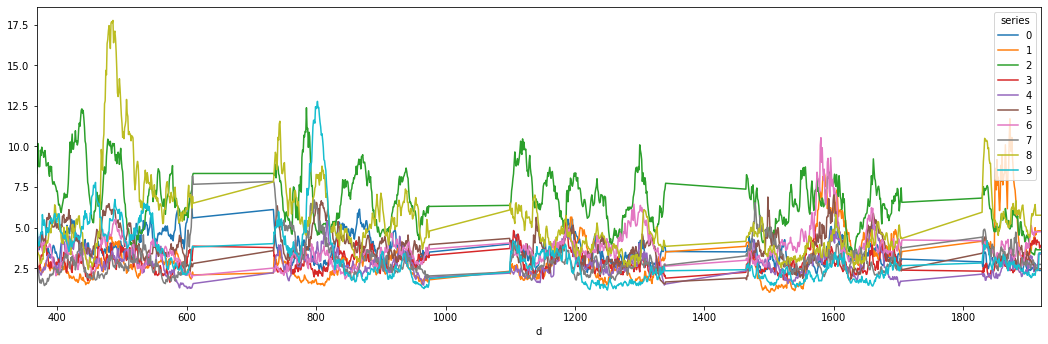

In [244]:
predictions.groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss')\
        .ewm(span = 7).mean().plot();

In [245]:
train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1_X,All,All,All,CA_1,CA,1.422434,1.362742,0.923581,1.000656,...,1.623811,2.048213,2.199738,1.498196,1.295179,1.310266,1.356510,1.453919,1.890456,2.062644
1,CA_2_X,All,All,All,CA_2,CA,1.145949,0.999016,0.695638,0.762217,...,1.587078,2.134142,2.200722,1.389964,1.299770,1.242702,1.324041,1.558216,2.335192,2.169236
2,CA_3_X,All,All,All,CA_3,CA,1.554280,1.583142,1.241391,1.387996,...,1.982945,2.305346,2.613644,1.932109,1.811414,1.762873,1.830108,1.817645,2.319777,2.671040
3,CA_4_X,All,All,All,CA_4,CA,0.532962,0.582814,0.454575,0.472286,...,0.864218,1.067891,1.088226,0.991801,0.890456,0.826173,0.834372,0.886848,1.031814,1.179731
4,TX_1_X,All,All,All,TX_1,TX,0.838308,0.881273,0.597573,0.740571,...,1.183995,1.242047,1.639882,1.216136,1.085602,1.032142,0.901279,1.201705,1.366678,1.516563
5,TX_2_X,All,All,All,TX_2,TX,1.263365,1.291243,0.895703,0.968842,...,1.448016,1.450968,1.923909,1.370613,1.314529,1.153821,1.025254,1.393572,1.574943,1.711053
6,TX_3_X,All,All,All,TX_3,TX,0.993768,0.985897,0.729747,0.711381,...,1.408659,1.362742,1.765497,1.423746,1.328960,1.216792,1.078386,1.439816,1.545425,1.631355
7,WI_1_X,All,All,All,WI_1,WI,0.886848,0.719580,0.512299,0.410298,...,1.304690,1.812725,1.799934,1.149557,1.089866,1.063299,1.140702,1.250574,1.640538,1.657593
8,WI_2_X,All,All,All,WI_2,WI,0.739915,0.630371,0.661856,0.827156,...,1.743850,2.526730,2.488029,1.643490,1.517875,1.486717,1.517875,1.600525,1.709741,1.662184
9,WI_3_X,All,All,All,WI_3,WI,1.324369,1.376845,1.087898,1.053132,...,1.307642,1.860938,1.933093,1.278124,1.084290,1.071827,1.114464,1.353231,1.482125,1.560184


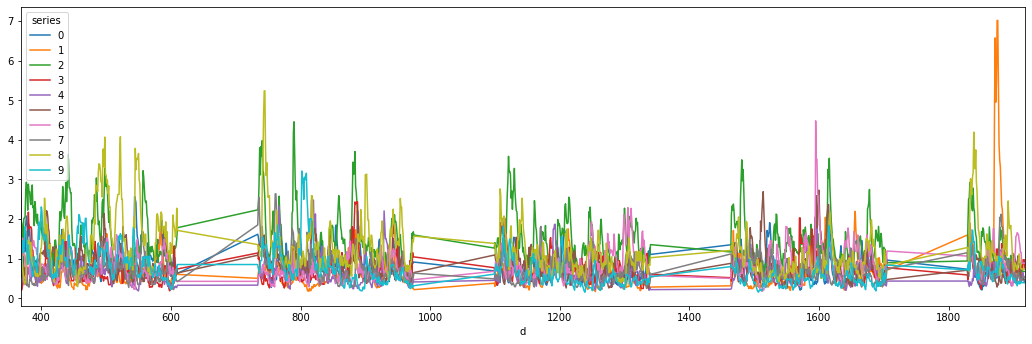

In [246]:
predictions[predictions.days_fwd < 7]\
        .groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss')\
        .ewm(span = 7).mean().plot();

In [247]:
# train_flipped.iloc[active_days,8].rolling(7).mean().plot();

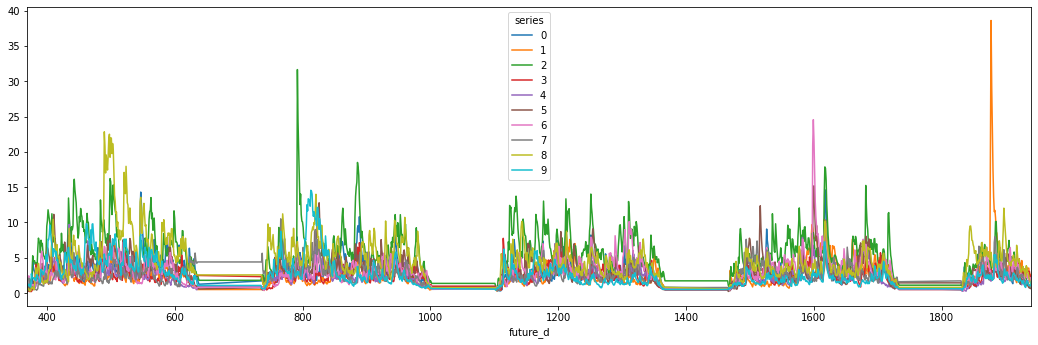

In [248]:
(predictions.groupby(['series', 'future_d']).wtg_loss.sum().reset_index()\
            .pivot('future_d', 'series', values='wtg_loss').ewm(span = 7).mean() \
).plot();

In [249]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().sort_values(ascending = False) #.ewm(span = 7).mean() \
# ).plot();

series  future_d
2       792         107.847135
1       1877         93.036267
6       1598         77.320359
1       1876         74.861670
8       490          58.611501
                       ...    
1       1271          0.053656
5       1466          0.047460
7       1108          0.044861
4       1003          0.044253
5       1106          0.039939
Name: wtg_loss, Length: 11622, dtype: float64

In [250]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().sum()

40338.843804954806

In [251]:
# cal.iloc[1515:1517]

In [252]:
# train_flipped.iloc[1500:1550,5]. plot();

In [253]:
# train_flipped.iloc[active_days,8]. plot();

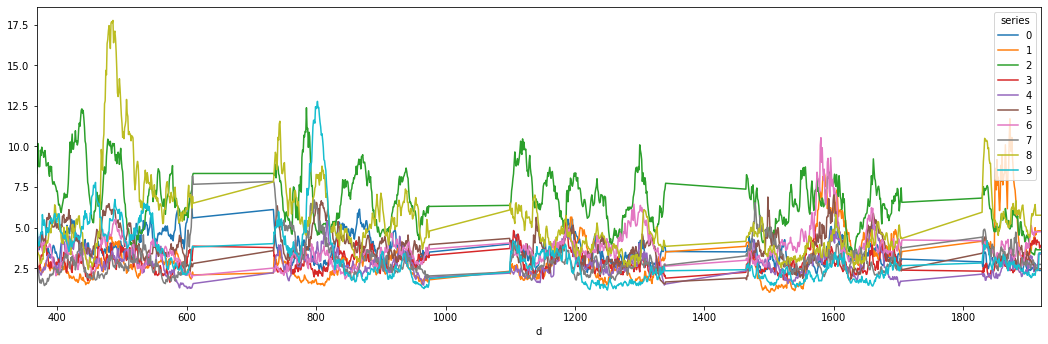

In [254]:
predictions.groupby(['series', 'd']).wtg_loss.sum().reset_index().pivot('d', 'series', values='wtg_loss')\
        .ewm(span = 7).mean().plot();

In [255]:
# train_flipped.iloc[active_days, 1].plot();

In [256]:
train_flipped

id,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,TX_3_X,WI_1_X,WI_2_X,WI_3_X
d_1,1.422434,1.145949,1.554280,0.532962,0.838308,1.263365,0.993768,0.886848,0.739915,1.324369
d_2,1.362742,0.999016,1.583142,0.582814,0.881273,1.291243,0.985897,0.719580,0.630371,1.376845
d_3,0.923581,0.695638,1.241391,0.454575,0.597573,0.895703,0.729747,0.512299,0.661856,1.087898
d_4,1.000656,0.762217,1.387996,0.472286,0.740571,0.968842,0.711381,0.410298,0.827156,1.053132
d_5,0.862578,0.636930,1.251886,0.503772,0.555592,0.817317,0.566087,0.000656,0.385372,0.699246
...,...,...,...,...,...,...,...,...,...,...
d_1937,1.310266,1.242702,1.762873,0.826173,1.032142,1.153821,1.216792,1.063299,1.486717,1.071827
d_1938,1.356510,1.324041,1.830108,0.834372,0.901279,1.025254,1.078386,1.140702,1.517875,1.114464
d_1939,1.453919,1.558216,1.817645,0.886848,1.201705,1.393572,1.439816,1.250574,1.600525,1.353231
d_1940,1.890456,2.335192,2.319777,1.031814,1.366678,1.574943,1.545425,1.640538,1.709741,1.482125


In [257]:
predictions[(predictions.series == 1) & (predictions.days_fwd < 7 )].set_index('future_d')\


,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct,loss_0.25,loss_0.5,loss,wtg_loss
future_d,,,,,,,,,,,,,,,
371,1,369,2,1.088867,1.145508,1.298458,0.137085,0.096130,0.139518,2012,20,0.382229,0.557868,0.940097,0.792646
373,1,370,3,0.730469,0.770996,0.738275,0.137207,0.095947,0.139310,2012,20,0.014223,0.119240,0.133464,0.112530
375,1,370,5,0.697754,0.727539,0.709741,0.137207,0.095947,0.134866,2012,20,0.021841,0.064859,0.086700,0.073101
376,1,370,6,0.720215,0.767090,0.800262,0.137207,0.095947,0.135593,2012,20,0.145852,0.120885,0.266737,0.224900
373,1,371,2,0.735840,0.780762,0.738275,0.137939,0.096436,0.140901,2012,20,0.004413,0.154005,0.158419,0.133571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,1,1914,3,1.397461,1.479492,1.437193,0.173218,0.109863,0.165833,2016,20,0.057343,0.122100,0.179443,0.151298
1919,1,1914,5,1.910156,1.955078,2.031158,0.173218,0.109863,0.181531,2016,20,0.174638,0.219607,0.394245,0.332409
1920,1,1914,6,1.298828,1.330078,1.454247,0.173218,0.109863,0.180213,2016,20,0.224312,0.358419,0.582731,0.491332


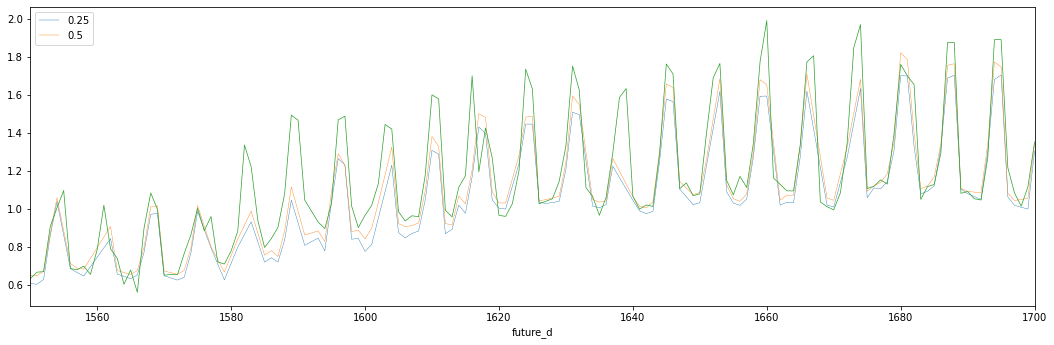

In [258]:
predictions[(predictions.series == 1) & (predictions.days_fwd < 7 )].groupby('future_d').mean()\
        [[c for c in predictions.columns if '.' in str(c) and 'loss' not in str(c)]]\
            .loc[1550:1700].plot(linewidth = 0.4)
train_flipped.iloc[:, 1].reset_index(drop=True).loc[1550:1700].plot( linewidth = 0.7);
# train_flipped.iloc[active_days, 1].iloc[1000:].plot();

In [259]:
train_flipped.iloc[active_days, 1].reset_index(drop=True)

NameError: name 'active_days' is not defined

In [260]:
train_flipped

id,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,TX_3_X,WI_1_X,WI_2_X,WI_3_X
d_1,1.422434,1.145949,1.554280,0.532962,0.838308,1.263365,0.993768,0.886848,0.739915,1.324369
d_2,1.362742,0.999016,1.583142,0.582814,0.881273,1.291243,0.985897,0.719580,0.630371,1.376845
d_3,0.923581,0.695638,1.241391,0.454575,0.597573,0.895703,0.729747,0.512299,0.661856,1.087898
d_4,1.000656,0.762217,1.387996,0.472286,0.740571,0.968842,0.711381,0.410298,0.827156,1.053132
d_5,0.862578,0.636930,1.251886,0.503772,0.555592,0.817317,0.566087,0.000656,0.385372,0.699246
...,...,...,...,...,...,...,...,...,...,...
d_1937,1.310266,1.242702,1.762873,0.826173,1.032142,1.153821,1.216792,1.063299,1.486717,1.071827
d_1938,1.356510,1.324041,1.830108,0.834372,0.901279,1.025254,1.078386,1.140702,1.517875,1.114464
d_1939,1.453919,1.558216,1.817645,0.886848,1.201705,1.393572,1.439816,1.250574,1.600525,1.353231
d_1940,1.890456,2.335192,2.319777,1.031814,1.366678,1.574943,1.545425,1.640538,1.709741,1.482125


In [261]:
train_flipped.iloc[active_days, 1].iloc[800:].plot();

NameError: name 'active_days' is not defined

In [262]:
train_flipped.iloc[active_days, 1]. rolling(7).mean()\
    .plot();

NameError: name 'active_days' is not defined

In [263]:
predictions[(predictions.series==8) & (predictions.d < 600)].wtg_loss.sum()

1666.7719358255972

In [264]:
active_days = list(set(
    [l for sublist in [list(range(d, d + 29)) for d in series_features.d.unique()] for l in sublist]) )
active_days = [d for d in active_days if d < len(train_flipped)]

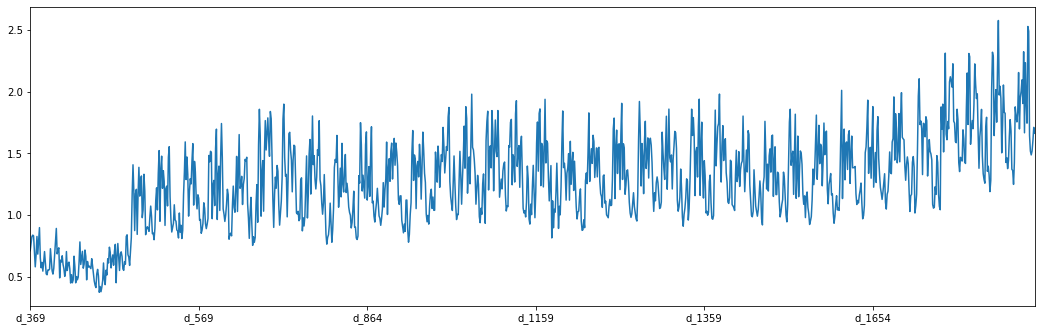

In [265]:
train_flipped.iloc[active_days,8]. plot();

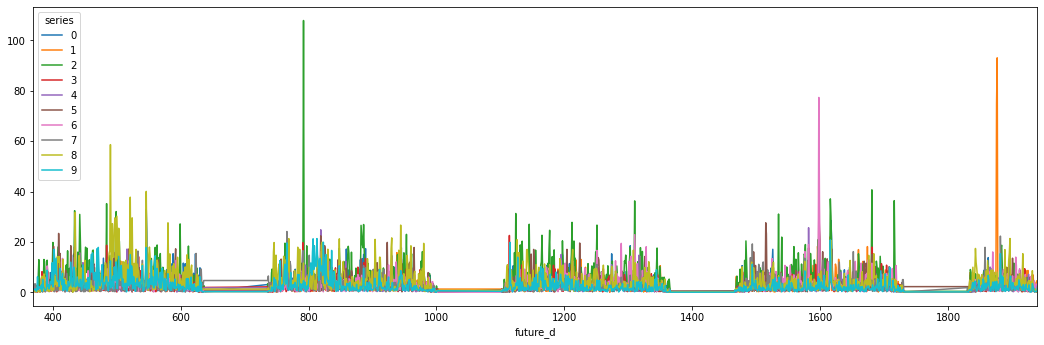

In [266]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().reset_index()\
        .pivot('future_d', 'series', values='wtg_loss') \
          .ewm(span = 1).mean().plot()

In [267]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().reset_index().pivot('future_d', 'series', values='wtg_loss').sum()

series
0    3784.486569
1    3243.537894
2    7087.513615
3    3058.398072
4    2966.282995
5    4032.343883
6    3911.911373
7    3202.550905
8    5678.222526
9    3373.595973
dtype: float64

In [268]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().sort_values(ascending=False)

series  future_d
2       792         107.847135
1       1877         93.036267
6       1598         77.320359
1       1876         74.861670
8       490          58.611501
                       ...    
1       1271          0.053656
5       1466          0.047460
7       1108          0.044861
4       1003          0.044253
5       1106          0.039939
Name: wtg_loss, Length: 11622, dtype: float64

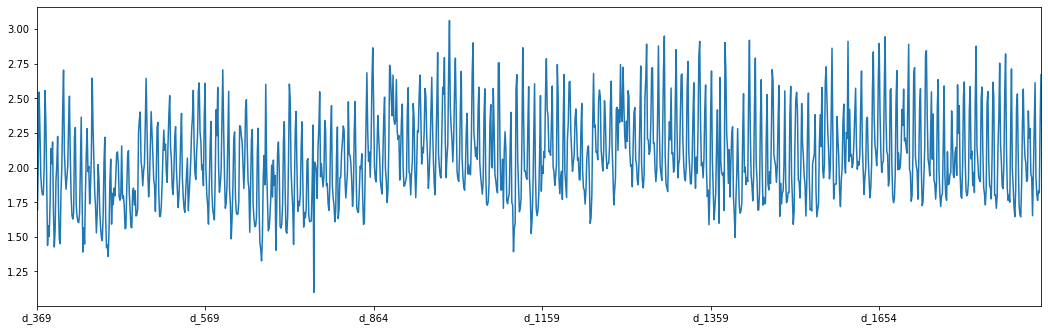

In [269]:
train_flipped.iloc[active_days, 2]. plot();

In [270]:
predictions.groupby(['series', 'future_d']).wtg_loss.sum().sort_values()

series  future_d
5       1106          0.039939
4       1003          0.044253
7       1108          0.044861
5       1466          0.047460
1       1271          0.053656
                       ...    
8       490          58.611501
1       1876         74.861670
6       1598         77.320359
1       1877         93.036267
2       792         107.847135
Name: wtg_loss, Length: 11622, dtype: float64

In [271]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sporting_holiday,cultural_holiday,national_holiday,religious_holiday
d,,,,,,,,,,,,,,,,,
d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,None,None,None,None
d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,None,None,None,None


In [272]:
losses = predictions.groupby('future_d').loss.mean().reset_index()
losses['d'] =  losses.future_d.map(cal_index_to_day)

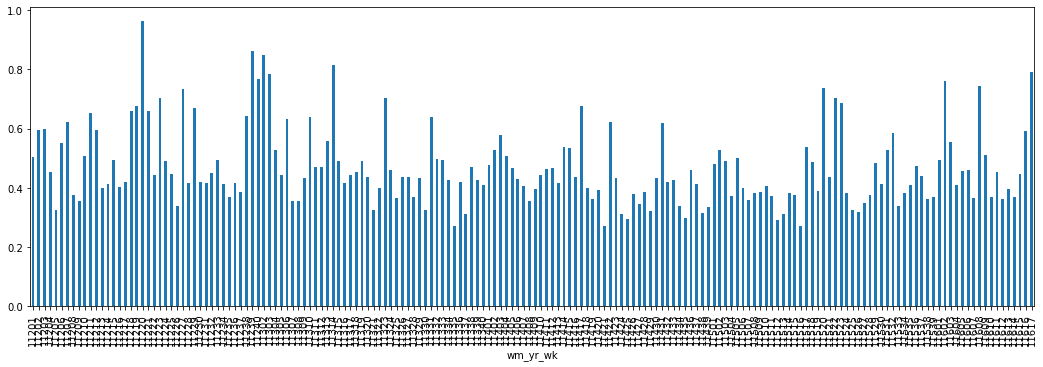

In [273]:
pd.merge(losses, cal, on ='d').groupby('wm_yr_wk').mean().loss.plot(kind='bar')

In [274]:
pd.merge(losses, cal, on ='d').groupby('wm_yr_wk').mean().loss.sort_values()

wm_yr_wk
11421    0.269755
11516    0.271376
11335    0.271792
11512    0.292534
11425    0.293362
           ...   
11617    0.790950
11314    0.813973
11302    0.849327
11239    0.863561
11220    0.963082
Name: loss, Length: 174, dtype: float64

In [275]:
cal[cal.wm_yr_wk == 11240]

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sporting_holiday,cultural_holiday,national_holiday,religious_holiday
d,,,,,,,,,,,,,,,,,
d_638,2012-10-27,11240,Saturday,1,10,2012,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_639,2012-10-28,11240,Sunday,2,10,2012,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_640,2012-10-29,11240,Monday,3,10,2012,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_641,2012-10-30,11240,Tuesday,4,10,2012,NaN,NaN,NaN,NaN,0,0,0,None,None,None,None
d_642,2012-10-31,11240,Wednesday,5,10,2012,Halloween,Cultural,NaN,NaN,0,0,0,None,Halloween,None,None
d_643,2012-11-01,11240,Thursday,6,11,2012,NaN,NaN,NaN,NaN,1,1,0,None,None,None,None
d_644,2012-11-02,11240,Friday,7,11,2012,NaN,NaN,NaN,NaN,1,0,1,None,None,None,None


In [276]:
predictions.groupby('d').loss.mean().sort_values(ascending= False)

d
477     0.873084
483     0.857094
488     0.814099
486     0.799351
479     0.791077
          ...   
1534    0.298651
1622    0.298454
1254    0.296729
1334    0.290615
1536    0.287756
Name: loss, Length: 1060, dtype: float64

In [277]:
predictions

,series,d,days_fwd,0.25,0.5,y_true,trailing_vol,weights,scaler,group,ct,future_d,loss_0.25,loss_0.5,loss,wtg_loss
0,0,368,2,1.189453,1.246094,1.400131,0.172485,0.119629,0.189488,2012,20,370,0.305357,0.446523,0.751880,0.633950
1,0,368,6,0.965820,1.014648,1.036077,0.172485,0.119629,0.186096,2012,60,374,0.101830,0.062118,0.163949,0.414702
2,0,368,10,1.341797,1.396484,1.791735,0.172485,0.119629,0.202630,2012,20,378,0.652140,1.145751,1.797891,1.515899
3,0,368,12,1.038086,1.060547,1.204985,0.172485,0.119629,0.199979,2012,20,380,0.241904,0.418698,0.660601,0.556988
4,0,368,20,0.894531,0.916504,0.925877,0.172485,0.119629,0.181813,2012,20,388,0.045433,0.027172,0.072605,0.061217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87726,9,1917,15,1.602539,1.738281,1.860938,0.176514,0.083923,0.197353,2016,40,1932,0.365976,0.347443,0.713418,1.203043
87727,9,1917,16,1.599609,1.737305,1.933093,0.176514,0.083923,0.185476,2016,20,1933,0.472320,0.554598,1.026917,0.865849
87728,9,1917,17,1.149414,1.221680,1.278124,0.176514,0.083923,0.190558,2016,20,1934,0.182295,0.159886,0.342181,0.288511
87729,9,1917,19,1.003906,1.042969,1.071827,0.176514,0.083923,0.203696,2016,20,1936,0.096197,0.081745,0.177942,0.150032


In [278]:
print('Total Time Elapsed: ', (datetime.datetime.now() - start).seconds, 's')

Total Time Elapsed:  12575 s


In [279]:
ramCheck()

2.9 GB used


In [280]:
memCheck()

                             X: 496.2 MiB
                    sample_sub: 87.6 MiB
                       scalers: 39.7 MiB
                  scaler_stack: 39.7 MiB
                   price_pivot: 32.8 MiB
                             y: 31.8 MiB
                        y_true: 31.8 MiB
                        groups: 19.8 MiB
                   predictions:  8.2 MiB
                          _277:  8.2 MiB


In [281]:
### NEXT: FOCUS ON STORE-ITEM CV:
# 2. Easy CV: diffsquared, then expanding means of it, stored on file
#             (y_true - y_pred) ** 2;  then for each prediction, just lookup denom value and divide by it
#             finally take sqrt(mean())
#             easy
# Probably just as fast to predict for every lag on every point, so comes out instantly as array_match;
# for now, it's an individual store-item onlyss

# doesn't make sense to go up a level until models predict just those, and apply that as overlay;
# then re-calc lower level, etc.

In [282]:
# copy in group loop from finance module, same for params and lgb, and printout CV code

# CV metric is tricky... differs for every day and every product and every lag 2k * 30k * 30 = 4gb...
# probably calculate this on-the-fly for a random subsample and see if converges...


In [283]:
# could predict all, or just call prediction code in full for one item and see; plot all 28-d forecasts vs ACTUAL
# or single-path printouts of history and pred/actual;
# ideally multiple items shown together etc.;


### Make Submission

In [284]:
FINAL_REPEATS = 1

In [285]:
final_base = train_flipped.index[-1]
print('Predicting 28 days forward from {}'.format(final_base))

final_features = series_features[series_features.d.map(cal_index_to_day) == final_base ]

Predicting 28 days forward from d_1941


In [286]:
X = []
for df in range(0,28):
    Xi = final_features.copy()
    Xi['days_fwd'] = df + 1
    X.append(Xi)
X = pd.concat(X); del Xi; del final_features;

In [287]:
X.shape

(280, 96)

In [288]:
X = pd.concat([X] * FINAL_REPEATS)

In [289]:
assert len(X) == 28 * train_flipped.shape[1] * FINAL_REPEATS

In [290]:
X.shape

(280, 96)

In [291]:
X, y, groups, scalers = getXYG(X, scale_range = SCALE_RANGE_TEST, oos = True)
Xd = X.d;  Xseries = X.series
X.drop(columns=['d', 'series'], inplace = True)

dropping 0 features; anything containing ['item_id', '_abs_diff', 'squared_diff', '336', '300d']
   -- []

XYG Pull Time: 0:00:00


In [292]:
X.shape

(280, 130)

In [293]:
assert len(X) == 28 * train_flipped.shape[1] * FINAL_REPEATS

In [294]:
y_pred = predictOOS(X, scalers, clf_set[LEVEL]); 

[1, 2, 3, 4, 5]
[0.06666666666666667, 0.13333333333333333, 0.2, 0.26666666666666666, 0.3333333333333333]
Bag Prediction Time: 0:00:00


In [295]:
y_pred.shape

(2, 280)

In [296]:
X

,qs_3d_ewm,qs_7d_ewm,qs_15d_ewm,qs_30d_ewm,qs_100d_ewm,qs_divbystore_3d_ewm,qs_divbystore_7d_ewm,qs_divbystore_15d_ewm,qs_divbystore_30d_ewm,qs_divbystore_100d_ewm,...,base_cultural_holiday,cultural_holiday,base_national_holiday,national_holiday,base_religious_holiday,religious_holiday,basedate_snap_day,basedate_nth_snap_day,snap_day,nth_snap_day
0,7.042969,6.449219,6.191406,6.027344,5.738281,7.042969,6.449219,6.191406,6.027344,5.738281,...,None,None,None,None,None,None,0,0,0,0
1,9.476562,8.453125,7.843750,7.460938,6.898438,9.476562,8.453125,7.843750,7.460938,6.898438,...,None,None,None,None,None,None,0,0,0,0
2,11.062500,10.148438,9.804688,9.695312,9.625000,11.062500,10.148438,9.804688,9.695312,9.625000,...,None,None,None,None,None,None,0,0,0,0
3,11.125000,10.359375,9.992188,9.726562,9.179688,11.125000,10.359375,9.992188,9.726562,9.179688,...,None,None,None,None,None,None,0,0,0,0
4,7.550781,6.914062,6.636719,6.464844,6.152344,7.550781,6.914062,6.636719,6.464844,6.152344,...,None,None,None,None,None,None,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,11.726562,11.992188,12.562500,12.718750,12.296875,11.726562,11.992188,12.562500,12.718750,12.296875,...,None,None,None,None,None,None,0,0,0,0
276,7.140625,6.800781,6.726562,6.640625,6.390625,7.140625,6.800781,6.726562,6.640625,6.390625,...,None,None,None,None,None,None,0,0,0,0
277,10.671875,9.843750,9.484375,9.265625,8.875000,10.671875,9.843750,9.484375,9.265625,8.875000,...,None,Father's day,None,None,None,None,0,0,0,0
278,13.007812,13.304688,13.937500,14.109375,13.640625,13.007812,13.304688,13.937500,14.109375,13.640625,...,None,Father's day,None,None,None,None,0,0,0,0


### Predict All and Save (Out of Date)

### Let's Examine Those Errors